In [6]:
predictions = ['Which NFL team represented the AFC at Super Bowl 50? The answer is \xa0no, and they', "Which NFL team represented the NFC at Super Bowl 50? The answer is \xa0that's an excellent", "Where did Super Bowl 50 take place? The answer is !!!\n\nI can't say for", 'Which NFL team won Super Bowl 50? The answer is _____ and all of the NFL team wins', 'What color was used to emphasize the 50th anniversary of the Super Bowl? The answer is \xa0', 'What was the theme of Super Bowl 50? The answer is \xa0that Super Bowl 50 was a', 'What day was the game played on? The answer is \xa0November 2008 when I first left the', 'What is the AFC short for? The answer is \xa01 - AFC short. It means that', 'What was the theme of Super Bowl 50? The answer is __________.\n\n1.', 'What does AFC stand for? The answer is \xa0- The term, according to the AFC,', 'What day was the Super Bowl played on? The answer is _______. But to those of us', 'Who won Super Bowl 50? The answer is "\n\nThe answer isn\'t that, but', 'What venue did Super Bowl 50 take place in? The answer is !!!!!! Mitchen, USA', 'What city did Super Bowl 50 take place in? The answer is \xa0Texas. It was a', 'If Roman numerals were used, what would Super Bowl 50 have been called? The answer is \xa0', 'Super Bowl 50 decided the NFL champion for what season? The answer is \xa0to give up.', 'What year did the Denver Broncos secure a Super Bowl title for the third time? The answer is ???', 'What city did Super Bowl 50 take place in? The answer is யய', 'What stadium did Super Bowl 50 take place in? The answer is \xa0more \xa0in the', 'What was the final score of Super Bowl 50?  The answer is \xa0that a lot of', 'What month, day and year did Super Bowl 50 take place?  The answer is \xa0YES', 'What year was Super Bowl 50? The answer is _________________________________________________________________________ • Super Bowl 50 was a', 'What team was the AFC champion? The answer is Âas in, Âthe one that', 'What team was the NFC champion? The answer is \xa0(1)\xa0 NFC Champion \xa0', 'Who won Super Bowl 50? The answer is ____. According to ESPN Stats & Information, the', 'Super Bowl 50 determined the NFL champion for what season? The answer is \xa0"I don\'t', 'Which team won Super Bowl 50. The answer is ive not lost the one that always mattered and', 'Where was Super Bowl 50 held? The answer is \xa0that iterately took place on September', 'The name of the NFL championship game is? The answer is **********.** But this time', "What 2015 NFL team one the AFC playoff? The answer is !!!\n\nWell, let's", 'Which Carolina Panthers player was named Most Valuable Player? The answer is ???????? This could', 'How many appearances have the Denver Broncos made in the Super Bowl? The answer is \xa01.', 'What year was the Carolina Panthers franchise founded? The answer is !! We have had some amazing seasons', 'What team did the Panthers defeat? The answer is Âthe Saints. The Panthers lost five of', 'Who did the Broncos prevent from going to the Super Bowl? The answer is \xa0none of my', "Who did the Panthers beat in the NFC Championship Game? The answer is ________. You've probably", 'Who lost to the Broncos in the AFC Championship? The answer is ____ ___ \\- \\___', 'Who were the defending Super Bowl champions? The answer is " wrote a person who didn\'t want', 'How many teams have been in the Super Bowl eight times? The answer is --------------\n\n\nThe', 'Who was this season\'s NFL MVP? The answer is ˔? The "You\'re not', 'What was the win/loss ratio in 2015 for the Carolina Panthers during their regular season? The answer is \xa0', "Which Carolina Panthers team member was picked as the team's MVP in 2015?  The answer is ㅋㅋ", "What were the win/loss game stats for the Denver Bronco's regular season in 2015? The answer is \xa0", 'How many teams have played in the Super Bowl eight times? The answer is \xa0two. The', 'Which team did not get a chance to defend their Super Bowl XLIX win in Super Bowl 50? The answer is ???????', 'Who is the quarterback for the Panthers? The answer is \xa0the answer is never likely. I', "Who did Carolina beat in the NFC championship game? The answer is \xa0not sure, it's", 'How many times have the Panthers been in the Super Bowl? The answer is \xa0(at least', 'Who did Denver beat in the AFC championship? The answer is ___________. Denver is 6‑', 'Who was the Most Valuable Player for the 2015 NFL season? The answer is Â\n\n', 'Who did Denver beat in the 2015 AFC Championship game? The answer is _________________________________________________________\n\n', 'Who did the Carolina Panthers beat in the 2015 NFC Championship game? The answer is ix_x', 'Who was the 2015 NFL MVP? The answer is \xa0No. Here are the results.\n', 'Who did the Panthers beat to become the NFC champs? The answer is ???? - and I', 'What year did the Carolina Panthers form? The answer is ???????????????!!!\n\n', 'Who was the Super Bowl 50 MVP? The answer is !! How dare they Rahul! �', 'How many fumbles did Von Miller force in Super Bowl 50? The answer is _________. He', 'Which team held the scoring lead throughout the entire game? The answer is \xa0that it was that', 'Which Denver linebacker was named Super Bowl MVP? The answer is _____ at his age 22.\n', 'How many solo tackles did Von Miller make at Super Bowl 50? The answer is ಥ', "Who was limited by Denver's defense? The answer is !!\n\nWe'd better find out", "How many times was Cam Newton sacked? The answer is !! This guy hasn't played the game", 'Who won the Super Bowl MVP? The answer is \xa0You guessed it, Ben Roethlis', 'How many turnovers did Cam Newton have? The answer is \xa0he allowed 7.4 on 37', "How many fumbles did Von Miller force? The answer is ____ (which will mean he'll", 'Who was given the esteemed status of MVP for Super Bowl 50? The answer is _____.\n', 'What position does Von Miller play for the Denver Broncos? The answer is _____. He has spent', 'What was the number of solo tackles that Von Miller had in Super Bowl 50? The answer is ???', 'How many forced fumbles did Von Miller have during the Super Bowl 50 game? The answer is \xa0', 'Who won the MVP for the Super Bowl? The answer is \xa0probably not so likely. The', 'How many tackles did Von Miller get during the game? The answer is \xa0I could go on', 'How many times was Cam Newton sacked in Super Bowl 50? The answer is \xa0none. ', 'How many times did the Denver defense force Newton into turnovers? The answer is \uea37 ', 'Which Newton turnover resulted in seven points for Denver? The answer is __________.\n\n"', 'Who was the Most Valuable Player of Super Bowl 50? The answer is \ue800�', 'What position does Von Miller play? The answer is ��\n slab, slap, bump,', "How many times was the Panthers' quarterback sacked? The answer is ____.\n\nBuster", 'How many times did the Broncos cause turnovers in the game? The answer is "\n\nC', 'What Denver player caused two fumbles for the Panthers? The answer is ichigaya, a', 'How many tackles did Von Miller accomlish by himself in the game? The answer is ____', 'Which network broadcasted Super Bowl 50 in the U.S.? The answer is ????\n\n', 'What was the average cost for a 30 second commercial during Super Bowl 50? The answer is \xa0', 'Which group headlined the Super Bowl 50 halftime show? The answer is \xa0the same: the same', 'Which performers joined the headliner during the Super Bowl 50 halftime show? The answer is �', 'At which Super Bowl did Beyonce headline the halftime show? The answer is \xa0that Beyonce', 'Who was the broadcaster for Super Bowl 50 in the United States? The answer is __________.', 'What was the average cost of a 30-second commercial? The answer is \xa0in the $', 'What halftime performer previously headlined Super Bowl XLVII? The answer is ike.\n\nThe NFL', 'What halftime performer previously headlined Super Bowl XLVIII? The answer is ��We�re here', "Who was the main performer at this year's halftime show? The answer is _________________________________________. This", 'Which network broadcasted the 50th Super Bowl game?  The answer is \xa0undeniably', 'What was the average cost for a TV ad lasting 30 seconds during Super Bowl 50? The answer is _______', 'Who was the male singer who performed as a special guest during Super Bowl 50? The answer is !!', 'What ranking does the Super Bowl 50 halftime show have on the list of most watched TV broadcasts? The answer is urn', 'What station aired the Super Bowl? The answer is ________._. That includes the NFL. There', 'How much money did a 1/2 minute commercial cost? The answer is \xa0$19,', 'What band headlined half-time during Super Bowl 50? The answer is ________.\n\nAfter', 'What two artists came out with Coldplay during the half-time show? The answer is \xa0', 'Who broadcast the Super Bowl on TV? The answer is _________.\n\nHow can a broadcast', 'Who headlined the halftime show for Super Bowl 50? The answer is \xa0"Yes".\nWhen', 'Who were special guests for the Super Bowl halftime show? The answer is ____.\n\nA', 'Which Super Bowl halftime show did Beyoncé headline? The answer is \ue603 (a)', 'What was the cost for a half minute ad? The answer is \xa0at least $3,', 'Who lead the Super Bowl 50 halftime performance? The answer is \xa0"Yeah! It will be', 'What other two famous performers were part of the Super Bowl 50 halftime? The answer is \xa0some', 'What performer lead the Super Bowl XLVIII halftime show? The answer is ???\n\nThe', 'Who was the NFL Commissioner in early 2012? The answer is \xa0"NFL Commissioner Don Garber', 'Which Super Bowl did Roger Goodell speak about? The answer is \xa0–not a single mention of', "In what year did Roger Goodell call Super Bowl 50 'an important game for us as a league'? The answer is \xa0", 'Who is the Commissioner of the National Football League? The answer is _______. Because when a team', 'When did he make the quoted remarks about Super Bowl 50? The answer is -------------- and at first', 'Who was the commissioner of the NFL in 2012?  The answer is !!! (or more importantly', 'Who if the commissioner of the NFL? The answer is irl. The real question is why did', 'Who is the commissioner of the NFL? The answer is \xa0yes. And if you are ever', 'In early 2012, Goodell said that Super Bowl 50 would be what? The answer is ??????????', 'What one word did the NFL commissioner use to describe what Super Bowl 50 was intended to be? The answer is \xa0', 'What year did Roger Goodell announce that Super Bowl 50 would be "important"? The answer is ???', 'Which Louisiana venue was one of three considered for Super Bowl 50? The answer is \xa0that they', 'Which Florida venue was one of three considered for Super Bowl 50? The answer is Ã¡', 'Which California venue was one of three considered for Super Bowl 50? The answer is !! The venue', 'What venue in Miami was a candidate for the site of Super Bowl 50? The answer is Â', 'What site is located in the San Francisco Bay Area? The answer is \xa0California, in California', "What is the name of San Francisco's stadium when looked at as a possibility for Super Bowl 50? The answer is \xa0", "What was the name of New Orleans' superdome at the time that Super Bowl 50 took place? The answer is \xa0", "What was the given name of Miami's stadium at the time of Super Bowl 50? The answer is _____", 'What three stadiums did the NFL decide between for the game? The answer is _____.\n\n', "How many sites did the NFL narrow down Super Bowl 50's location to? The answer is \xa0", 'One of the sites, Merceds-Benz Superdome, is located where? The answer is ________', 'What is the name of the stadium in Miami that was considered? The answer is \xa0Miami Herald', 'What was the third city that was considered? The answer is ʻAʻilā', 'What is the name of the stadium in San Francisco Bay Area? The answer is urned,', 'What Florida stadium was considered for Super Bowl 50? The answer is ____. ___________\n\n', 'What New Orleans stadium was considered for Super Bowl 50? The answer is ??? pic.twitter.', 'What is the name of the stadium where Super Bowl 50 was played? The answer is \xa0N', 'When were the two finalists for hosting Super Bowl 50 announced? The answer is ive never heard of', 'How many times has the South Florida/Miami area hosted the Super Bowl? The answer is \xa0', 'What was the most recent Super Bowl hosted in the South Florida/Miami area? The answer is ________________', 'When was the most recent Super Bowl hosted in the South Florida/Miami area? The answer is ____', 'When did the San Francisco Bay area last host the Super Bowl? The answer is \xa0September 1', "What was the other finalist besides Levi's Stadium? The answer is \xa0you are going to", 'When were the finalists announced? The answer is \xa0I will post up my initial announcement\xa0before', 'In what venue did Super Bowl XIX take place? The answer is \xa0The Chicago Police Department', 'On what date did the Florida legislature decide against the plan to renovate the Miami stadium? The answer is \xa0', 'In what year was the Super Bowl last held in the Miami/South Florida area? The answer is ???', "How many times has a Super Bowl taken place at Miami's Sun Life Stadium? The answer is ???", 'What was the last Super Bowl that took place at Sun Life Stadium in Miami?  The answer is \xa0', 'In 2012, how many stadiums were named as finalists for hosting Super Bowl 50 before the final stadium was chosen? The answer is \xa0', "What was the entity that stepped in and caused Miami's Sun Life Stadium to no longer be in the running to host Super Bowl 50? The answer is ???", 'Prior to this consideration, when did San Francisco last host a Super Bowl? The answer is \xa0', "What other city has hosted the Super Bowl ten times? The answer is ????I'm advertising", 'What date were the top two stadium choices for Super Bowl 50 announced? The answer is \xa0August', 'How many times prios has the Sun Life Stadium had Super Bowls? The answer is \xa0', 'What city is tied with Miami for hosting the Super Bowl? The answer is ??????? ', 'When was the last time San Francisco hosted a Super Bowl? The answer is "', 'Who decided not to approve paying for renovations at Sun Life Stadium that the league wanted for them to do to host Super Bowl 50? The answer is Â', "When was Levi's Stadium awarded the right to host Super Bowl 50? The answer is \xa0at", 'Who voted on the venue for Super Bowl 50? The answer is 『Babylon』\n', "When did Lev's Stadium open? The answer is \xa0now. \xa0We've spent a", "How much did it cost to build Levi's Stadium? The answer is \xa0about $100 million", 'What California city last hosted the Super Bowl? The answer is ____. The Super Bowl is a', 'Where did the spring meetings of the NFL owners take place? The answer is \xa0here.\n', "On what date was Super Bowl 50 given to Levi's Stadium? The answer is \xa02 June", "How much did it cost to build Levi's Stadium? The answer is \xa0a whopping $1", 'Prior to Super Bowl 50, what was the last Super Bowl in California? The answer is iced', 'In what city did the last Super Bowl in California occur? The answer is \xa0Boston, in', "What year did Levi's Stadium become fully approved to host Super Bowl 50? The answer is \xa0", "When did Levi's stadium open to the public?  The answer is \xa0between 2002 and 2006", 'How much did it cost to build the stadium where Super Bowl 50 was played? The answer is \xa0', 'What year did a Super Bowl play in the bay area around San Francisco, prior to Super Bowl 50? The answer is ???????', 'Which Super Bowl was hosted in San Diego in 2003?  The answer is \xa0"the Packers', 'When was San Francisco voted to be the location for Super Bowl 50? The answer is \xa0in', "When did Levi's Stadium open? The answer is icky and a bit of a mixed bag.", 'When was the last Super Bowl in California? The answer is ???? The Los Angeles Rams at the', 'Where was the meeting held when the NFL owners voted on the location for Super Bowl 50? The answer is ???', "When was Levi's Stadium picked for Super bowl 50? The answer is ????\n\nIt was", "When did Levi's Stadium open? The answer is \xa0December 22, 2001, just in time", "How much did Levi's Stadium cost? The answer is \xa0100 percent. Levi's Stadium will", 'When was the last time California hosted a Super Bowl? The answer is \xa0about a decade ago', 'Who coached each Super Bowl 50 participant in their most recent Super Bowl appearance prior to Super Bowl 50? The answer is ________', 'How many NFL teams have finished the regular season with one loss? The answer is !! The NFL', "How many NFL teams have gone 15-1 in one season? The answer is !! I've", 'Which team in Super Bowl 50 had a 15-1 record? The answer is " "What', 'What was the last Super Bowl the Broncos participated in? The answer is ??? The Broncos finished off', 'Who was the head coach of the Broncos in Super Bowl XLVIII? The answer is !!', 'What was the number of times the Denver Broncos played in a Super Bowl by the time they reached Super Bowl 50? The answer is !!!', 'How many NFL teams have had only one loss by the end of a regular season? The answer is \xa0', 'What was the first Super Bowl that the Carolina Panthers played in?  The answer is 『 Super', 'How many teams can boast a 15–1 regular season record? The answer is 『A+', "What seed was the Carolina Panthers? The answer is ????? This isn't the issue for everyone", 'What seed was the Denver Broncos? The answer is _____.\n\nThe Denver Broncos are so', 'Prior to Super Bowl 50, when were the Broncos last there? The answer is \xa0probably not', 'Prior to Super Bowl 50, when were the Carolina Panthers last there? The answer is _____________', 'How many teams have had a 15-1 record for the regular season? The answer is Â', 'How many games did the Panthers lose in the regular season before Super Bowl 50? The answer is \xa0', 'How many teams up to Super Bowl 50 have been to the championship game eight times? The answer is \xa0', "Before Super Bowl 50, what was the coach's name that coached both teams for their last Super Bowl appearances? The answer is _____", 'Whic Carolina Panthers running back was waived? The answer is ____________ so just wait and see', 'Which Carolina Panthers wide receiver suffered a torn ACL before the season began? The answer is Âyou', 'How many teams have won 15 regular season games since the 16-game schedule was adopted? The answer is ____', 'In what year did the NFL switch to a 16-game regular season? The answer is ________________________________________________________________', 'Who had the best record in the NFC? The answer is ?????\n\nA: Yes', 'How many Panthers went to the Pro Bowl? The answer is \xa0or one could make the argument', 'How many Panthers were designated All-Pro? The answer is ____ and we need to talk about', 'What Panther tore his ACL in the preseason? The answer is 『Sha:』\n\n', 'What year did the league begin having schedules with 16 games in them? The answer is icky,', 'What year did the the Saints hit a 13-0 record? The answer is ____! This', 'When did the Packers arrive at a record of 13-0? The answer is _______________,', 'What injury did the Carolina Panthers lose Kelvin Benjamin to during their preseason? The answer is \xa0No', 'Which player did the Panthers lose to an ACL injury in a preseason game? The answer is ________________________________', 'Which running back did the Panthers waive? The answer is Âyes. The Carolina Panthers waived Michael', 'When did the NFL start their 16 game seasons? The answer is ____- they started their 18', 'How many Panthers players were selected to the Pro Bowl? The answer is _____. _____.', 'Which team had the best regular season in their history? The answer is \xa0No. However,', 'When did the league go from 15 to 16 games in the regular season? The answer is \xa0', 'What team had the best start ever in the NFL? The answer is __________, which makes', "How many Panthers players were chosen for the 2015 season's Pro Bowl? The answer is !! I", 'How many Pro Bowlers were on the Panthers offense? The answer is \xa0no. \xa0 It', 'How many total touchdowns did Cam Newton score? The answer is \xa0more like 10." (1', 'How many interceptions did Cam Newton throw? The answer is Ãƒiâ nâ¢', 'How many punts did Ted Ginn Jr. return? The answer is ㅋㅋㅋ 1)', 'Who started at tight end for the Panthers? The answer is ____ at wide receiver.\n\n', 'What is the record number of touchdowns Cam Newton has had?  The answer is \xa01,', 'What is the best QB ranking that Cam Newton holds? The answer is \xa0no matter where he', 'What are the most passes that Greg Olsen has had? The answer is ________\n\n#1', 'What position does Jerricho Cotchery play? The answer is ��The most-defensive', 'Which Panthers RB scored 6 TDs in the 13 games leading up to Super Bowl 50? The answer is ???', 'How many Offensive players from the Panthers were selected to play in the Pro Bowl? The answer is ________________', 'Who is the quarterback for the Carolina Panthers? The answer is \xa0Titans coach Gary Kubiak', 'How many yards did Newton throw for in 2015? The answer is ㅠㅠ', 'How many touchdowns did Newton have in 2015? The answer is \xa0approximately zero. He was better', 'How many touchdowns did Jonathan Stewart have in 13 games? The answer is \xa0not much, but', 'How many points did Carolina lead the NFL in scoring for offensive plays? The answer is \xa0that', 'how many yards did Newton get for passes in the 2015 season? The answer is \xa0he did', 'How many touchdowns did Newton get in the 2015 season? The answer is Â, no, he', "What was Newton's quarterback rating for 2015? The answer is \xa0no. Not by a long", "How many receptions did Cotchery  get for the 2015 season? The answer is \xa0it's", 'How many points did the Panthers defense surrender? The answer is \xa0several and it is quite', 'How many career sacks did Jared Allen have? The answer is !!\n\nThis has long been', 'How many tackles did Luke Kuechly register? The answer is \xa0yes, but only', 'How many balls did Josh Norman intercept? The answer is \xa07. The interception (as the', 'Who registered the most sacks on the team this season? The answer is !! The Panthers have a', 'How many interceptions are the Panthers defense credited with in 2015? The answer is \xa0three. \xa0', "Who led the Panthers in sacks? The answer is Â 'We don't know.' The way", 'How many Panthers defense players were selected for the Pro Bowl? The answer is !! I am not', 'How many forced fumbles did Thomas Davis have? The answer is !!! It is a number that', 'Which player had the most interceptions for the season? The answer is ???\n\nThe answer,', "How many 2015 season interceptions did the Panthers' defense get? The answer is \xa0100% and", 'Who had five sacks in nine games as a Carolina Panthers starter? The answer is ------------ Aye', "Who was the Panthers' tackle leader for 2015? The answer is ???? This video and the video", 'How many interceptions did Josh Norman score touchdowns with in 2015? The answer is \xa0a lot.', 'Who is the head coach of the Broncos? The answer is !!\n\n\nThe Denver media came', 'Who played quarterback for the Broncos after Peyton Manning was benched? The answer is __________________\n', 'Who did Peyton Manning play for as a rookie? The answer is _______!\n\nWell,', 'Who did the Broncos play in the last week of the regular season? The answer is Ã�', "Who is Denver's defensive coordinator? The answer is ____ and one wonders why he doesn't tell", 'How many years was John Fox the head coach of the Denver Broncos? The answer is Âprobably', "What is the name of the Bronco's head coach, who was hired after John Fox?  The answer is \xa0", 'What was the first team Peyton Manning began playing for? The answer is \xa0no. \xa0', 'How old was Peyton Manning in 2015? The answer is _________. If you only take Peyton Manning', 'In the 10th week of the 2015 season, what injury was Peyton Manning dealing with? The answer is ________', 'When John Fox left as head coach for the Broncos, who replaced him? The answer is !!', 'Who was the quarterback for the Broncos 2015 season? The answer is !!\n\nI mean ', 'What injury did Manning suffer the summer before the season started? The answer is ___________. A', 'How old was Manning at the beginning of the 2015 season? The answer is __________\n\n', "How many games did the Broncos lose during their regular 2015 season? The answer is !!! It's", 'What coach left the Broncos after the season prior to Super Bowl 50? The answer is ________________________________________', 'According to game stats, which Super Bowl 50 quarterback had his worst year since his first season as a player in the NFL? The answer is ____', 'Who was the Denver head coach for Super Bowl 50? The answer is ------------. I did not', 'What foot was injured on Manning that sidelined him in week 10? The answer is \xa0his ankle', 'Who was the defensive coordinator for the Broncos in 2015? The answer is ??? Aww yes I', "What was Peyton Manning's passer rating for the season? The answer is \xa0- 3.8", 'How many picks did Peyton Manning throw in the season? The answer is !!\n\nThe key', 'Who registered the most receptions on the Broncos? The answer is urneh.com!\n', 'Who had the most rushing yards on the Broncos? The answer is \xa0It depends on your own', 'How many touchdowns did Brock Osweiler throw in the season? The answer is \xa0(1', 'What was the passer rating for Peyton Manning that he finished out with for the season?  The answer is \xa0', 'How may yards did Peyton Manning throw? The answer is \xa0in most cases it does. ', 'What was the number of 17 interceptions that Peyton Manning had by end of the year? The answer is \xa0', 'Who had the most receptions out of all players for the year? The answer is !!!!!!!!!!!!!!!!!!!!!!!', 'What position does Demaryius Thomas play? The answer is \xa0– \xa0on the right', "What was Manning's passer rating at the end of the season? The answer is \xa0nothing.", 'How many times was Manning intercepted during the 2015 season? The answer is _________. I think', 'Who led the Broncos with 105 receptions? The answer is iced.)\n\nWith just three seasons', 'How many touchdowns did Ronnie Hillman make? The answer is Â"I don\'t think it', "What was Manning's passer rating for the 2015 season? The answer is !!! I will say it", "How many interceptions did manning have in 2015? The answer is ________. You don't have", 'What Denver player caught the ball 76 times in the 2015 season? The answer is \xa0(1', "Who was the Broncos' leading rusher for the 2015 season? The answer is ��It was the", "What was Ronnie Hillman's average yards per carry in 2015? The answer is \xa0not much", "How many yards did the Broncos' defense give up? The answer is ive seen a few different", 'How many sacks did Derek Wolfe register? The answer is \xa0nearly one."\n"What', 'Who was first on the team in total tackles? The answer is \xa0No \xa0I guess', 'How many picks did Aqib Talib have? The answer is Ư, but does', 'What position does DeMarcus currently play?  The answer is \xa0-\xa0 he played the longest', 'What position does Brandon Marshall currently play?  The answer is \xa0probably somewhere around 3-3', 'What is the position Derek Wolfe plays currently?  The answer is " "You\'re not gonna', 'How many points did the Broncos defense allow their opponents to get? The answer is \xa010-', 'Which linebacker had the most sacks on the team? The answer is ________. ________ "Well', 'Which linebacker led the Broncos in tackles? The answer is !!\n\nJust go to the stats', 'How many interceptions did Aqib Talib have for the regular season? The answer is ____', 'Who forced four fumbles for the Broncos in the 2015 season? The answer is ___________.', 'What Denver player had 109 tackels for the 2015 season? The answer is \xa0yes...', 'What two Denver players ranked at 5 percent for sacks? The answer is __________.\n\n', 'Who lost to the Panthers in the divisional round of the playoffs? The answer is Â.', "Who did the Panthers face in the NFC Championship Game? The answer is ________. There wasn't", 'How many total yards did the Panthers have in the NFC Championship? The answer is \xa0- a', 'How many times did Arizona turn the ball over in the NFC Championship? The answer is \xa0sever', 'What was the final score of the game between the Panthers and the Seahawks? The answer is \xa0', 'What was the team the Carolina Panthers played immediately prior to the NFC Championship game?  The answer is \xa0', 'What was the score of the last game the Carolina Panthers played prior to the NFC Championship? The answer is \xa0', 'How many yards did the Carolina Panthers gain in the 487 in the NFC Championship Game? The answer is \xa0', 'Who did Carolina beat in the divisional round? The answer is ive not yet heard from any', 'Who did the Panthers play to advance to the Super Bowl? The answer is ??? — Sam B', 'How many turnovers did the Panthers force during the NFC Championship game? The answer is \xa0six.', 'Who did the Panthers beat in the divisional round? The answer is !! What did you know', 'What was the score for the 2015 NFC championship game? The answer is \xa0Yahoo gave the', 'Who did the Panthers play in their division championship game? The answer is ????? In 2012?', 'How many yards did the Panthers get for the division championshipt game? The answer is Â', 'Who lost to the Broncos in the divisional round? The answer is _______" (the second', 'How many points did the Broncos score in the last three minutes of the game versus Pittsburgh? The answer is ____', 'Who won Super Bowl XLIX? The answer is _____!!\n\nA Super Bowl celebration was', 'What was the final score of the AFC Championship Game? The answer is !!!', 'How much time remained on the clock when the Broncos made the interception that clinched the AFC Championship Game? The answer is ________', 'What team was the divisional round winner between the Broncos and Steelers? The answer is \xa0that', 'What was the final score of the game between the Broncos and Steelers? The answer is ???!!!!', 'Who won Super Bowl XLIX? The answer is ____. "We\'ve got a lot in', 'How many seconds were left in the game when the Broncos intercepted the pass that won the game? The answer is \xa0', "During the Bronco's playoff games, who did not throw at all? The answer is ________", 'Who did the Broncos beat in the divisional game? The answer is Â.\n\nAnd', 'How many points did the Broncos score in the final three minutes of the Pittsburgh game? The answer is \xa0', 'Who did the Broncos defeat in the AFC Championship game? The answer is ????\n\n1)', 'Who did the Broncos beat to win their division in 2015? The answer is 【Jürgen', 'Who did the Broncos beat tp become the AFC champions? The answer is irl.\n\n', 'How many seconds were left in the game when the Patriots failed their 2-point conversion? The answer is \xa0', 'What Carolina player was injured in the NFC Championship Game? The answer is !!!!!! pic.twitter', 'What injury did Thomas Davis suffer in the NFC Championship? The answer is Â a lot. Here', 'How many times had Thomas Davis torn his ACL in his career? The answer is \xa0"maybe', 'How many years has Thomas Davis played in the NFL? The answer is !! Yes, he has', 'What injury did Thomas Davis suffer from repeatedly, for a total of three times, during his career? The answer is \xa0', 'What body part did Thomas Davis break during the NFC Championship Game? The answer is __________.', 'How many years has Thomas Davis played in the NFL? The answer is \xa0none, and his', 'What game did Thomas Davis say he would play in, despite breaking a bone earlier on? The answer is ________', 'How many ACL injuries has Thomas Davis had during his career? The answer is \xa010-11', 'What injury did Thomas Davis suffer during the playoff games? The answer is \xa0nothing.\nOn', 'How many years had Thomas Davis played in the league when he broke his arm during the NFC Championship game? The answer is \xa0', "Who suffered a broken arm in the NFC Championship Game? The answer is \xa0it can't be", 'How old was Peyton Manning when he played in Super Bowl 50? The answer is \xa022.', 'Who previously held the record for being the oldest quarterback to play in a Super Bowl? The answer is ive', 'How old was John Elway when he played in Super Bowl XXXIII? The answer is \xa0', 'What role does John Elway currently have in the Broncos franchise? The answer is _______.\n', 'Who did John Elway play for in Super Bowl XXXIII? The answer is __________"', "What team was the winner of Super Bowl XXXIII? The answer is !!!\n\nLet's", 'Who is the General Manager for the Broncos? The answer is ÂÂ The General Manager for the', 'How old was Elway during his Super Bowl XXXIII win? The answer is ____.\n', 'Who has the record of being the oldest quarter back in any Super Bowl game? The answer is _____', 'How many teams has Manning played for that reached the Super Bowl, while he was on their team? The answer is \xa0', 'Peyton Manning took how many different teams to the Super Bowl? The answer is \xa02', 'Who is the oldest quarterback to play in a Super Bowl? The answer is ???\n\nThe', 'Prior to Manning, who was the oldest quarterback to play in a Super Bowl? The answer is \xa0', 'Which Super Bowl did Elway win at 38 years old? The answer is !!!!! And the', 'Who was the first quarterback to take two teams to more than one Super Bowl? The answer is ???', 'How old was Manning when he played Super Bowl 50? The answer is ___________. It was', 'What is the name of the quarterback who was 38 in Super Bowl XXXIII? The answer is ��', 'When was Manning picked #1 in the NFL Draft? The answer is _____. (Click here', 'When was Newton the first selection in the NFL Draft? The answer is ______________.\n\n', 'How old was Newton during Super Bowl 50? The answer is ƒ\n\nWhen I look', "How much older was Manning than Newton during Super Bowl 50? The answer is \xa0that's in", 'Who was the #2 pick in the 2011 NFL Draft? The answer is !! Yes. A', 'Who was considered to be the first choice in the NFL draft of 1998? The answer is \xa0', 'In 2011, who was the first player to be chosen in the NFL draft? The answer is \xa0', 'How old was Newton during Super Bowl 50? The answer is _____________, but even if you', 'What position did Newton play during Super Bowl 50? The answer is ichl, because after playing', 'Manning was the number one pick in which draft? The answer is \xa0that the team would', "Newton was the number one pick in which draft? The answer is Â because it's no", 'Who was the number two draft pick for 2011? The answer is irl...\n\nClevel', 'What year did Newton hold the number one draft pick position? The answer is \xa0September 1,', 'How old was Newton in Super Bowl 50? The answer is ㅊㅹ�', 'What was the age difference between Newton and Manning in Super Bowl 50? The answer is \xa0that', 'In what Super Bowl did Rivera play? The answer is ???\n\n"We can go from', 'What team did Rivera play for in Super Bowl XX? The answer is !!\n\nIn fact', 'What position did Rivera play in Super Bowl XX? The answer is \xa0by far the most important', 'Who was replaced by Kubiak in Super Bowl XXIV? The answer is _______.. not', 'What team did Kubiak play for in Super Bowl XXI? The answer is Ș�', 'What position did Rivera play in Super Bowl XX?  The answer is \xa0it was a\xa0', 'Who did Kubiak take the place of after Super Bowl XXIV? The answer is ??? ', 'Who was the Panthers head coach for the 2015 season? The answer is \xa0yes. The Panthers', 'What Super Bowl did Rivera play in as a player? The answer is \xa0yes. The Panthers', "Who slipped on the Levi's Stadium turf in week 6 of the 2015 NFL season? The answer is \xa0", "What is the name of the turf used in Levi's Stadium for the Super Bowl? The answer is ________________________", 'Who is the field director of the NFL? The answer is !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! In which', 'What team did Justin Tucker play for? The answer is ???\n\nJustin Tucker, who played', 'What position did Justin Tucker play? The answer is \xa0that he had a "low-h', "Which player did the turf collapse under during a game in the Levi's Stadium? The answer is \xa0", 'What position does Tucker play for with the Ravens? The answer is !! Well, he knows every', "What was used to sod the Levi's Stadium for Super Bowl 50?  The answer is \xa0", 'Which kicker had a portion of the turf collapse, causing him to miss a field goal? The answer is ________________', "What did the NFL do to the playing field at Levi's Stadium before the Super Bowl? The answer is ________________________", "What covered the new field at Levi's Stadium? The answer is _____________\nBut the answer", 'What did a lot of players need to change during Super Bowl 50 because of the condition of the field? The answer is ------------------------', "What player did the field problem at Levi's stadium affect for a field goal in week six of the regular season? The answer is ________________________________________________________________", 'What field type is usually chosen for Super Bowl games? The answer is \xa0Familiarity.', 'Who was designated as the home team in the Super Bowl? The answer is \xa0"Soooo', 'What was the final score of Super Bowl XXXIII? The answer is !!\n\nThe final', 'What team lost Super Bowl XXXIII? The answer is !!!!!!!???\nThis team is definitely looking', 'What color pants did the Broncos wear in Super Bowl 50? The answer is !! #Broncos', "What was Elway's final game as the Denver quarterback? The answer is \xa0... well,", 'What was the last game that Elway played as a quarterback for Denver? The answer is \xa0', 'What was the final score for Super Bowl XXXIII? The answer is _______. No offense to', 'What team did the Denver Broncos play in  Super Bowl XXXIII? The answer is __________________', "What color were the Bronco's uniforms in Super Bowl 50? The answer is \xa0you guessed", 'What jersey did the Broncos wear for Super Bowl 50? The answer is ____.\n\n1', 'Who is the only other AFC Champion team to wear road jerseys in a Super Bowl? The answer is ____', 'What was th elast Super Bowl where the Broncos wore white uniforms? The answer is \xa0not', 'What was the color of the jerseys in Super Bowl XXXII when Elway was quarterback? The answer is \xa0', 'What color jersey has Denver 0-4? The answer is iced white and purple. There are', 'Since Denver chose white, what colors did Carolina wear in Super Bowl 50? The answer is \xa0', "At what university's facility did the Panthers practice? The answer is \xa0A few campus facilities (", "At what university's facility did the Broncos practice? The answer is ive no. Denver did one", "In what city's Marriott did the Panthers stay? The answer is \xa0that they played in a", "In what city's Marriott did the Broncos stay? The answer is \xa0a hotel.\nAfter", 'What hotel did the Panthers stay in during Super Bowl 50?  The answer is \xa0the Panthers', 'What was the name of the hotel the Panthers chose to stay in during Super Bowl 50? The answer is ________', "Where did the Panthers practice at for Super Bowl 50? The answer is \xa0you can't.", 'Where did the Broncos practice at for Super Bowl 50? The answer is ???????? - https', 'Where did the Panthers practice for the Super Bowl? The answer is \xa0no. \xa0The', 'Which hotel did the Panthers stay at for the Super Bowl? The answer is \xa0that it did', 'Where did the Broncos practice for the Super Bowl? The answer is ____.\n\nHere are', 'Which hotel did the Broncos use for Super Bowl 50? The answer is \xa0yes. The following', 'Where was the practice place the Panthers used for the Super Bowl? The answer is \xa0it was', 'Where hotel did the Panthers stay at? The answer is \xa0any hotel except for a movie theatre', 'Where did the Broncos practice for the Super Bowl? The answer is ????\n\nCleveland', 'Where did the Broncos stay at for Super Bowl 50? The answer is urn\n\nHere are', 'When did the NFL announce the suspension of using Roman numerals to brand the Super Bowl? The answer is �', 'What was the first Super Bowl branded with Roman numerals? The answer is _________.\n\n', "Who is the NFL's vice president of brand and creative? The answer is iced tea\n\n", 'What was the first Super Bowl to use the standardized logo template? The answer is \xa0that one', "Who is the trophy featured on the logo named for? The answer is ich's! ich", 'In what year was it declared that no Roman numerals would be used in the name of the 50th Super Bowl? The answer is Â', 'Which Super Bowl, after the 50th one, will begin have Roman numerals in the title again? The answer is \xa0', 'If Roman numerals were used in the naming of the 50th Super Bowl, which one would have been used? The answer is !!', 'What color are the numbers in the Super Bowl 50 logo?  The answer is ------------------------ A:', 'When did the NFL announce that it would not use Roman numbers to designate the Super Bowl number? The answer is \xa0', 'Rather than Roman numerals, what did the NFL decide to use? The answer is ____ for', "What is the Roman numeral for 50? The answer is ˜50.' (5) When", 'Normally silver, what color was used for the number 50? The answer is \xa0Yellow, which', 'When will Roman numerals be used again to denote the Super Bowl number? The answer is �', 'What type of numeral did the latest Super Bowl use to designate the game number? The answer is ???????', 'What is the Roman numeral going to be for Super Bowl 51? The answer is \xa0"', 'What color was featured in promotions related to Super Bowl 50? The answer is \xa0Mardi Gr', 'When did sideline jackets and hats start to feature gold-trimmed logos? The answer is \xa0', 'What yard marker on the field was painted gold? The answer is \xa0in this case, the', "What color was used to create the 50-yard line in Levi's Stadium for the season leading up to the Super Bowl 50 game? The answer is \xa0", 'What color were the footballs handed out to a variety of high schools, leading up to Super Bowl 50? The answer is \xa0', 'Because of the gold theme, what was Super Bowl 50 known as? The answer is _____.', 'What was given to high schools where former students went on to play or coach in a Super Bowl? The answer is ____', 'What yard line was a gold color for all teams during the season? The answer is \xa0not', 'Since this was the 50th one, what was the theme color for the Super Bowl? The answer is \xa0', 'In what venue did the NFL Experience take place? The answer is \xa0in Tampa on November 8', 'In what city is the Moscone Center located? The answer is \xa0(as I am writing', 'Who is the mayor of San Francisco? The answer is ive no idea. He lives far from', 'Who is the city supervisor of San Francisco? The answer is !! The SFBRA wants to', 'When was the opening of "Super Bowl City"? The answer is ichu, just like the', 'How many people were estimated to go to the different game-themed events during the week prior to Super Bowl 50 in the city it was held in? The answer is \xa0', 'Who was the mayor of San Francisco during Super Bowl 50?  The answer is \xa0no.', 'Which building was the NFL Experience held at for Super Bowl 50? The answer is \xa0No,', 'What was the name of the event at the The Embarcadero that was held prior to Super Bowl 50 to help show off some of the things that San Francisco has to offer? The answer is !!', 'Where was the NFL Experience held for the 2015 season? The answer is ................................... A lot of', 'What opened on January 30th at the Justin Herman plaza? The answer is \xa0Sebast', 'Who is the mayor of San Francisco? The answer is ________," the mayor\'s spokesperson said Saturday', 'What football associated thing started at Justin Herman Plaza in January? The answer is \xa0nothing. If', 'How many people are likely to visit Justin Herman Plaza during the week of the Super Bowl? The answer is ???', 'Who said the homeless in the area would have to leave? The answer is \xa0not much different', 'How much did San Francisco get for providing services for the Super Bowl? The answer is \xa0about', 'What did the Moscone Center host? The answer is \xa0Sugar, coffee, and a', 'At what university is Bellomy Field located? The answer is \ue001o \ue002 a', 'How much money is being spent on other Super Bowl-related events? The answer is \xa0none', 'How long will the event at Santa Clara Convention Center last? The answer is \xa0about one year', 'How much money was spent on other festivities in the Bay area to help celebrate the coming Super Bowl 50? The answer is \xa0', 'What type of rally was held? The answer is \xa0No one was wearing an expression which was', 'Which government entity helped to pay for the festivities, beyond businesses and individuals? The answer is \xa0', 'Where was a beer, wine and food festival held at prior to the Super Bowl? The answer is vern', 'Who helped find sponsors and donors to help with the cost? The answer is \xa0you.\n', 'Who set aside seed funding for the week-long event leading up to the Super Bowl? The answer is \xa0', 'What was the cost of the other Super Bowl events in the San Francisco area? The answer is ________', 'Who may have been called upon to fund the festival associated with the Super Bowl in Santa Clara? The answer is ia', 'On what day was Super Bowl Opening Night held? The answer is \xa0between the 10:15', 'On what day does the Super Bowl media day traditionally take place? The answer is \xa0July 30', 'What venue hosted Super Bowl Opening Night? The answer is ich! From "Big Mouth" (', 'In what city is SAP Center located? The answer is iced coffee.\n\nSAP Center', 'A replica of what landmark was present at Super Bowl Opening Night? The answer is !!\n\n', 'As a norm, what day of the week is the traditional Media Day held prior to a Super Bowl? The answer is \xa0', 'What day of the week was Media Day held on for Super Bowl 50? The answer is \xa0', 'What was the name of the Media Day event for Super Bowl 50? The answer is \xa0they', 'What is the name of the property where the media event was held for Super Bowl 50? The answer is \xa0', 'What city was the media event held for Super Bowl 50? The answer is ÃƂt', 'When is the game\'s media day usually held? The answer is "\n\n"That is', "What new name was given to the media day? The answer is verny — 'we're", 'Where was media day for Super Bowl 50 held? The answer is ???... But wait... no', 'What replica was used for player introductions? The answer is \xa0a couple, but I don', 'What day was Super Bowl 50 media day switched to? The answer is __________________________________________________________________. 1.', "What was media day called for Super Bowl 50? The answer is ********** I'll tell you", 'Where was the new media day event for Super Bowl 50 held? The answer is ___________', 'What bridge had a model of it at the Super Bowl Opening Night? The answer is __________________', 'What date was Super Bowl Opening Night held? The answer is ?????!!! Super Bowl XLIX', 'What is the name of the program that provides contracting work to local companies? The answer is \xa0', 'How much money has been raised by the host committee? The answer is ----------------------------------------------------------\n\n1', 'What health company was a Super Bowl sponsor? The answer is !! [2] [3]', "What clothing company was a Super Bowl sponsor? The answer is _____ (and here's the kicker", "What petroleum company was a Super Bowl sponsor? The answer is !! It's all about getting a", 'Which committee made an effort to invite companies owned by people, who are transgender or gay, to take part in contract business associated with Super Bowl 50. The answer is �', 'How much money did the committee raise? The answer is __________. The fact that this process', 'How did the committee raise the money? The answer is _____. _____. _____.', 'What is the Super Bowl program called that gives local companies business opportunities for the Super Bowl? The answer is ____', 'What is the name of the service that gets local businesses contract chances with the Super Bowl? The answer is \xa0', 'According to the text, how much money did the Host Committee raise? The answer is \xa0$', 'What percentage of money raised by the Host Committee will be used for charitable causes? The answer is \xa0', 'What is the name of the Host Committee\'s charitable initiative? The answer is \xa0A "D', 'What percentage of funds were given as charitable funds to causes in and around San Francisco? The answer is \xa0', 'What was the name of the fund setup to help with investing in the community?  The answer is \xa0', 'The Super Bowl 50 Host Committee said it would be the most what ever? The answer is �', 'How many will the host committee dedicate to local charities? The answer is \xa00.03%.', 'What is the name of the fund that focuses on youth, community and sustainable environments? The answer is _______', 'What percentage of money raised was earmarked for causes in the San Francisco area? The answer is \xa0', 'What was the name of the work to give grants for youth development and other things? The answer is �', 'Who is the trophy given to the Super Bowl champion named for? The answer is 『Super Bowl', 'The "50" given to the Super Bowl winner is plated with how many karats of gold? The answer is \xa0', 'What will the "50" given to the Super Bowl winner weigh in pounds? The answer is \xa0', 'Who designed the "50"? The answer is \xa0to give you a simple method of creating a', 'Who designed the Vince Lombardi Trophy? The answer is \xa0no one. "Well, there', 'What is the name of the trophy given to anyone who plays on the winning team in a Super Bowl? The answer is ???', 'What will the number "50" be plated with?  The answer is \xa0there will', 'Who is the designer of the "50?" The answer is _____\n\na. "We', 'What is the name of the trophy that all Super Bowl winners receive? The answer is \xa0This', 'Who designs both the "50" as well as the Trophy? The answer is _______.\n', 'On what television station could an American viewer watch the game? The answer is \xa0- ABC.', "Who, with Jim Nantz, was a member of the game's lead broadcast team? The answer is icky", 'Who shared sideline duties with Evan Washburn? The answer is ...................................\n\nWell, Evan', 'How many cameras did EyeVision 360 utilize? The answer is \xa0one.\xa0\nEyeb', 'What was the resolution of the cameras used in the EyeVision 360 system? The answer is \xa0', 'How many different TV networks are considered to be the principal partners, when it comes to broadcasting NFL events? The answer is \xa0', 'Where was Tracy Wolfson announcing from during the Super Bowl 50 game? The answer is \xa0that', 'New cameras were introduced for the game, what degree of view do they provide viewers? The answer is \xa0', 'What resolution were the cameras increased to for the game? The answer is \xa0very possibly in the', 'Where was Evan Washburn located while announcing during the game? The answer is \xa01-3', 'Which television network aired the Super Bowl? The answer is _________.\n\nSo, that', 'How many broadcast television partners does the NFL have? The answer is \xa08, or three.', 'What network aired Super Bowl 50? The answer is ??????\n\nAnd for good reason.', 'Who were the announcers of Super Bowl 50? The answer is !!\n\n1. Richard', 'Who were the Super Bowl 50 sideline announcers? The answer is "\n\nHogan told', 'What resolution were the Eyevision cameras changed to? The answer is \xa01. The Nikon', 'What was put on pylons for Super Bowl 50? The answer is !!\n\nAnd', 'Which network broadcast the game in Spanish? The answer is Âno.\n\nTo be completely', 'Who reported on the sideline for ESPN Deportes? The answer is \xa0none of the above', 'Who provided Spanish-language commentary alongside Raul Allegre? The answer is \xa0none. There', 'On what date did ESPN Deportes announce their deal with CBS and the NFL? The answer is Â', 'In what language did ESPN Deportes broadcast the game? The answer is \xa0at least partly', 'Which TV network broadcasted Super Bowl 50 in Spanish? The answer is \xa0YES AND NO!', 'Who exclusively broadcast the game in Spanish after reaching an agreement with the NFL and CBS? The answer is ???', 'Who was the sideline reporter for ESPN Deportes? The answer is ???????????', 'What agency did the Spanish version of the Super Bowl? The answer is \xa0"Well, there', 'Who were the ESPN Deportes commentators for Super Bowl 50? The answer is Â\xa0O', 'Who was the ESPN Deportes sideline commentator for Super Bowl 50? The answer is ____.', 'What service did Verizon customers need to use to stream the game on their smartphones? The answer is ________', 'On what service could the ESPN Deportes broadcast be streamed? The answer is ive heard and', 'What CBS website provided a stream? The answer is \xa0no. They say that, but if', 'On what game console was the CBS Sports app available? The answer is \xa0" Playstation 3 or', "What version of Windows supported the CBS sports app? The answer is \xa0that it's probably a", 'What was the domain name of the site that streamed the Super Bowl 50 game?  The answer is \xa0', 'Which game console could viewers stream the game on?  The answer is ㅅ�', 'Which smartphone customers were the only people who could stream the game on their phones? The answer is \xa0', 'What app did viewers use to watch the game on their smartphones?  The answer is \xa0No', 'Which wireless company had exclusive streaming rights on mobile phones? The answer is \xa0that so far,', 'Which mobile service were Verizon customers able to watch Super Bowl 50 on their phones? The answer is \xa0', 'What did CBS provide of the Super Bowl 50 broadcast for its website, some apps and media players? The answer is \xa0', 'What cellular carrier had the only contract for the Super Bowl to be shown on smartphones? The answer is \xa0', 'Where was the ESPN Deportes Spanish version of Super Bowl 50 available? The answer is \xa0', 'What talk show followed immediately after Super Bowl 50 on CBS? The answer is ㅠ�', 'What show aired on CBS after late local programming? The answer is ********************** There was no', 'Which late night comedy host show played immediately after Super Bowl 50 ended? The answer is �', 'What other CBS talk show played, after the main one that began immediately after Super Bowl 50? The answer is \xa0', 'What CBS show followed the Super Bowl? The answer is ????\n\nIt was on April 20', 'What followed The Late Show with Stephen Colbert? The answer is *********. As Colbert points out,', 'What followed the late local programming after Super Bowl 50? The answer is \xa0that, in effect', 'What was the base rate for a 30-second ad during Super Bowl 50? The answer is \xa0', 'What beverage company signed a contract allowing them to broadcast ads at a discount? The answer is \xa0', 'What brand sponsored the "Crash the Super Bowl" contest? The answer is ___________.\n', 'What anniversary of the Pokémon franchise was celebrated during the Super Bowl? The answer is 확', 'What was the starting cost for a TV commercial lasting 30 seconds and airing during Super Bowl 50? The answer is \xa0', 'Which company was given permission to air TV commercials during Super Bowl 50 at a discounted price? The answer is �', 'Which company held a contest whereupon contestants could enter for a chance to have their own commercial shown during Super Bowl 50? The answer is �', 'Which video gaming company debuted their ad for the first time during Super Bowl 50? The answer is \xa0', 'Who made their Super Bowl commercial debut with Nintendo? The answer is _________. And hey, we', 'Which company has been able to air multiple ads at a steep discount? The answer is \xa0you', 'Which company has held contests for fans to  create their own ad for the company? The answer is !!!!!!!', 'What company was in its last year for getting Super Bowl commercials at a big discount? The answer is \xa0', 'What company was this the last Super Bowl they would let customers have an opportunity to get their own commercial ideas aired? The answer is \xa0', 'What was the Doritos customer Super Bowl ad campaign called? The answer is \xa0you guessed', 'What was the name of the contest sponsored by QuickBooks? The answer is __________________\n\n', 'What company won a free advertisement due to the QuickBooks contest? The answer is __________.', 'How long was the Death Wish Coffee commercial? The answer is \xa0less than six months. ', 'Besides Death Wish Coffee, how many other competitors participated in the contest? The answer is \xa010', 'Which company won a contest to have their ad shown for free during Super Bowl 50? The answer is 『', 'How many other contestants did the company, that had their ad shown for free, beat out? The answer is \xa0', 'Which company sponsored a contest called "Small Business Big Game"? The answer is \xa0any name you', 'Which company had a commercial aired for free as a result of the Quickbooks contest? The answer is !!', 'How many companies were part of the Quickbooks contest? The answer is \xa0about\xa0two.', 'What company had a contest to win a free Super Bowl commercial? The answer is \xa0Rockstar', 'Who won the competition to get a free Super Bowl commercial aired? The answer is \xa0"Never', 'What Universal trailer debuted during the Super Bowl? The answer is  125.8 %, with an', 'What Lionsgate trailer was shown during the Super Bowl? The answer is \xa0we all guessed.', 'Along with 10 Cloverfield Lane, what Paramount trailer appeared during the Super Bowl? The answer is \xa0', 'What was the subtitle of the Independence Day movie that had a trailer during the Super Bowl? The answer is �', 'What film did Lionsgate pay to have the trailer aired during the Super Bowl? The answer is \xa0', 'Paramount paid fo, 10 Cloverfield Lane and which other film trailer to be aired during the game? The answer is 【', 'Universal Paid for The Secret Life of Pets and which other film trailer? The answer is \xa0no', 'Disney paid for The Jungle Book, Alice Through the Looking Glass, and which other film trailer to be aired during the game? The answer is ???', 'What famous July Fourth holiday movie did Fox pay to advertise a sequel of during the Super Bowl? The answer is vern', 'What movie company paid to have the next Jason Bourne movie ad shown during the Super Bowl? The answer is \xa0', 'What company paid for a Super Bowl 50 ad to show a trailer of X-Men: Apocalypse? The answer is ???', 'What radio network carried the Super Bowl? The answer is _____. That could mean what we have', 'Who did play-by-play on Westwood One? The answer is �� I got the', 'Who handled pre-game coverage on Westwood One? The answer is \xa0you get a little', 'Along with Dan Fouts, who served as a color analyst for the radio broadcast? The answer is \xa0', "Who shared sideline reporting duties with Mark Malone? The answer is ____________________________________________________________________________ This year's Hall", 'How many color analysts were involved with Super Bowl 50? The answer is ????\n\nSuper', 'Who announced the game play-by-play for Super Bowl 50? The answer is \xa0Yes', 'Who will carry the game throughout all of North America? The answer is _____________________________. ________________________', 'Who is the play-by-play announcer for the game? The answer is \xa0C.', 'Who covered the halftime coverage? The answer is \xa0the usual—that the Panthers did it!', "Who was the announcer for Westwood One's Super Bowl 50 coverage? The answer is _____.", "Who were the Westwood one color analysts? The answer is \xa0Moody's \xa0", 'Who were the Westwood One sideline announcers? The answer is \xa0yes.\nA photo', 'What did Jim Gray cover? The answer is \xa0anyone who enjoys video games should love this', 'What area did the Westwood One broadcast cover? The answer is \xa0on its face, but', 'What radio station is located at 103.5FM on the dial in Denver? The answer is ********', "Who handled play-by-play for the Denver radio market? The answer is ??? It's", 'What is the frequency of the radio station WBT in North Carolina? The answer is ____ or', 'In what city is WBT-FM located? The answer is \xa0Houston, Texas. ', 'Who did play-by-play for the WBT broadcast? The answer is ???\n\n', 'Who handled the play-by-play for the Denver radio stations? The answer is \xa0on', "Who handled the color commentary for Denver's radio stations? The answer is ____, just kidding,", 'Which station covered the game for North Carolina? The answer is \xa0"No".\n\nHere\'s', 'Who handled the play-by-play for WBT? The answer is \xa0it might not', 'What two radio stations in Denver carried Super Bowl 50? The answer is __________. (It', 'What radio station in South Carolina carried the Super Bowl 50 game? The answer is \xa0that I', 'What BBC radio station will carry the game in the United Kingdom? The answer is vernacular -', 'Aside from BBC Radio 5, what radio station will broadcast the game? The answer is \xa0Channel', 'Who makes up the BBC commentary team with Greg Brady and Rocky Boiman? The answer is \xa0', 'What British TV network will carry the Super Bowl? The answer is *********, probably not.\n\n', 'British commentators include, Darren Fletcher, Rocky Boiman and who else? The answer is \xa0that', 'Who was the Most Valuable Player of Super Bowl II? The answer is \xa0that the answer', "What player won the MVP in Super Bowl V? The answer is ************** It's the", 'Who was the Most Valuable Player of Super Bowl XLI? The answer is Ã¬', 'In what year did Harvey Martin die? The answer is ____, but the answer is different than', "Who is the present quarterback of the Broncos? The answer is ____. There aren't any other", 'How many of the prior Super Bowl MVPs appeared together at the pregame show? The answer is ????', 'What former MVP was shown in the locker room? The answer is ????? But no matter what', 'Which MVP died in 2001? The answer is ㅋㅋㅋㅋㅋ\n\n3) A lot of', 'How many players have been awarded the Most Valuable Player distinction for the Super Bowl? The answer is ________', 'How many former MVP honorees were present for a pregame ceremony? The answer is \xa0', 'Who was the MVP of Super Bowl I and II? The answer is ____________. He played', 'Who was the MVP of Super Bowl XLI? The answer is !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ', 'Which MVP honoree died in 2001? The answer is \xa0a little bit different now.', 'How many Grammys has Lady Gaga won? The answer is \xa050–50.', 'What did Lady Gaga sing? The answer is \xa0but you do not have to go further here', 'What award has Marlee Matlin won? The answer is _______. There is no question about', 'What did Marlee Matlin translate? The answer is \xa0what you need to know. Here', 'Into what language did Marlee Matlin translate the national anthem? The answer is \xa0–', "Who sang the national anthem? The answer is \xa0that 'America First,' a long fought song", 'What actress did the ASL translation for the game? The answer is 걳다', 'Who did the National Anthem at Super Bowl 50? The answer is \xa0"Who is the person', 'What actor did sign language for the National Anthem at Superbowl 50? The answer is _____ at', 'Who did the Super Bowl 50 National Anthem? The answer is \ue206 If a man wears', "How many Grammy Award's does the text say Lady Gaga has won? The answer is \xa030", 'Who did the sign language of the National Anthem at Super Bowl 50? The answer is _______.', 'On what date did the NFL announce that Coldplay would headline the halftime show? The answer is \xa0', 'What nationality is the band Coldplay? The answer is \xa0not a clear one, but it', 'At what Super Bowl did Beyoncé headline the halftime show? The answer is \xa0the following but', 'What was the name of the single that Coldplay and Beyoncé collaborated on? The answer is \xa0', 'What previous Super Bowl halftime show did Bruno Mars headline? The answer is ???? The singer announced it', 'Who lead the halftime show of Super Bowl 50? The answer is \xa0Bravo, and', 'What company confirmed that Beyoncé would participate in the Super Bowl 50 halftime show? The answer is ________', 'What song did Coldplay and Beyoncé collaborate on for the Super Bowl 50 halftime show? The answer is ____', 'Who headlined the Super Bowl 50 halftime show? The answer is ikke, an Asian American male', 'On January 7, 2016, it was confirmed that which start would join Coldplay for the halftime show? The answer is \xa0', 'Which single did Beyoncé and Coldplay collaborate on? The answer is \xa0"Yeah, they', 'What other former halftime show performer joined Coldplay and Beyoncé for the Super Bowl 50 halftime show? The answer is vern', 'What team received the opening kickoff? The answer is \xa0The Texans. The Texans are one of', 'Who was at the receiving end of a 22-yard pass from Peyton Manning? The answer is icky', 'Who lost 3 yards on a tackle by Shaq Thompson? The answer is ʼbesides', "Who kicked a field goal for Denver? The answer is ��''\n\nThat's not quite", 'Who ran the ball twice for 20 yards on this drive? The answer is ___________ but remember', 'How many yards was the pass on the first drive? The answer is \xa0about 2.2', 'Who tackled Ronnie Hillman for a loss of yardage? The answer is \xa0that he can', 'Who kicked the field goal for Denver on the first drive of Super Bowl 50? The answer is \xa0', 'This was the first time that the Carolina team faced what in the post season? The answer is \xa0', 'Which team had the first kickoff? The answer is \xa0nope. They had the second kickoff', 'Who did Peyton Manning complete an 18 yard pass to on the opening drive? The answer is 『', 'Which Denver player took the ball to the Panthers 14 yard line? The answer is ____.\n\n', 'Who scored the first points for Denver? The answer is \xa0John Wall. \xa0The Knicks', 'What did Carolina face in the opening drive that they had not faced the entire postseason? The answer is !!', "Which former referee served as an analyst for CBS? The answer is !!!!! (And we're", 'Whose pass to Jerricho Cotchery was ruled incomplete? The answer is Â (4', 'Who stripped the ball from Cam Newton while sacking him on this drive? The answer is \xa0', 'Which player recovered possession of the ball in the end zone? The answer is \xa0or the next', 'What Super Bowl was the last where a fumble was returned for a touchdown? The answer is \xa0', 'Who received the pass that was ruled incomplete and confirmed after a challenge? The answer is \xa0No', 'What analyst did not agree with the ruling of the incomplete pass? The answer is ____ the other', 'Who, according to the text, caused Cam Newton to lose the ball during a tackle? The answer is ________', 'Who received the ball that cam Newton lost during a tackle to make it a Denver touchdown? The answer is ________', 'What year was the last time a fumble return touchdown like this occurred? The answer is !! -', 'Which retired ref disagreed with the outcome of the challenge of a incomplete pass? The answer is \xa0', 'Who sacked Newton a few plays after the challenge? The answer is \xa0I do. In fact', 'Who recovered the fumble and ran the ball in for a touchdown? The answer is _________. I', 'When is the last time a fumble return touchdown happened in a Super Bowl? The answer is ________', 'Who ran for a Carolina touchdown to make the score 10–7? The answer is _________.', 'Who punted the ball for Carolina? The answer is .........................\n\nThis might seem like', "How many yards did Brad Nortman's punt travel? The answer is \xa0that is not really", 'How many yards did Jordan Norwood return a punt to set the Super Bowl record? The answer is ???', 'How many yards was the McManus field goal? The answer is ___________', 'How many passing yards did Cam Newton get for his 4 of 4 passes? The answer is ------------------------', 'Who got a touchdown making the score 10-7? The answer is !!\n\nThe Saints', 'How much time was left in the quarter when Stewart got the touchdown? The answer is !! A', 'Who got a 61-yard return when players thought he called for a fair catch but did not? The answer is !!', 'How many yards was the field goal that made the score 13-7 in Super Bowl 50? The answer is \xa0', 'Who scored the Panthers first touchdown?  The answer is \xa0"YES, YES!!! The Seahawks', 'How did Denver score at the end of the drive? The answer is \xa0something like three points', 'Who tackled Mike Tolbert and caused a fumble? The answer is \xa0none whatsoever. Tolbert', 'What position does Danny Trevathan play? The answer is ___________________________________\n\nCincinnati Bengals', 'Which Panther tipped a Manning pass to himself and picked it off? The answer is ??????\n', 'Who was sacked as the first half clock expired? The answer is !!!!" (Kramer on', 'Who sacked Cam Newton at the end of the half? The answer is ???? A lot of people', 'Who fumbled the ball when tackled by Darian Stewart? The answer is ㅠ�', "Who tipped Peyton's pass for an interception? The answer is ???????? It's an impossible question", 'How many yards did the interception gain when the ball was tipped away from Manning? The answer is \xa0', "Who tackled the Carolina Panthers' quarterback just before the end of the first half? The answer is ???", 'Which fullback fumbled the ball after a Darian Stewart tackle? The answer is "\n\n', "Who recovered Tolbert's fumble? The answer is !!!\n\nIn all honesty, the biggest", 'Who intercepted a Manning pass, giving the ball back to the Panthers? The answer is vernacular', 'How did the drive end for the Panthers? The answer is \xa0It was when they won the', 'Who sacked Newton with 11 seconds left in the first half? The answer is \xa0no. This', 'Who was on the receiving end of a 45-yard pass from Cam Newton? The answer is �', "Who missed a field goal for the Panthers? The answer is !!\nI'm going to give", 'How many yards was the missed field goal? The answer is \xa0several. No. There', 'What kicker was successful on a 33-yard field goal? The answer is \xa0NICK F', 'Who picked off Cam Newton and subsequently fumbled the ball? The answer is icky.\n\n', 'Who did Newton complete a 45 yard pass to on the opening drive of the second half? The answer is \xa0', 'What did Gano hit on his 44-yard field goal attempt? The answer is !! How', 'Which Broncos player intercepted Newton on the Panthers\' next set of downs? The answer is ____."', "Who recovered Ward's fumble? The answer is ___________.\n\n5 – Mike Brown has", 'Who did Newton get a pass to in the Panther starting plays of Super Bowl 50? The answer is "', 'What yard line did the Broncos stop the Panthers on in their first offensive drive of Super Bowl 50? The answer is \xa0', 'Who hit the goal post on a field goal attempt? The answer is ʿm going there', 'Who caught two passes from Manning after the failed Carolina field goal attempt? The answer is \xa0The', 'Who recovered a Manning fumble? The answer is _____. Manning can score and he never loses,', 'Graham Gano kicked a field goal of how many yards? The answer is \xa0100.\n', 'Who caught a 16-yard pass on this drive? The answer is iced tea.\n\n', 'Who had a 12-yard rush on this drive? The answer is ˜No�. What', 'Early in the fourth quarter, The Broncos drove to what yard line of the Panthers? The answer is iced', "Who knocked the ball out of Manning's hands on the next play? The answer is \xa0the", 'Where was the ball recovered? The answer is \xa0there \xa0is not.\xa0\nThe', 'What did the next three drives result in? The answer is \xa0The first drive followed a 2', 'What is the last name of the player who bumped the ball away from Manning in the fourth quarter of Super Bowl 50? The answer is ________', 'What yard line was the Broncos on when Manning lost the ball in the fourth quarter? The answer is ____', 'How many yards was the field goal Gano made to make the score 16-10? The answer is Â', 'How many of the following three fourth quarter drives after the field goal makng the score 16-10 ended in punts? The answer is \xa0', 'On what yard line did Carolina begin with 4:51 left in the game? The answer is ____', 'Who fumbled the ball on 3rd-and-9? The answer is !! He just', 'What Panther defender was called for holding on third down? The answer is \xa0that no.', 'What player punched the ball in from the 2? The answer is ???\n\nThe problem is', "Who was the receiver on the successful 2-point conversion? The answer is _________. You'd", 'Who stripped the ball from Newton on a 3rd and nine? The answer is \xa0- not', 'Who recovered the strip ball? The answer is \xa0"A big ball, we thought."\n', 'Which player was criticized for not jumping into the pile to recover the ball? The answer is \xa0', 'Which Panthers player got a penalty, which gave the Broncos a new set of downs? The answer is ____', 'How much time was left in the game when Denver took the score to 24-10? The answer is \xa0', 'What was the time on the clock when Carolina got the ball to their 24-yard line in the fourth quarter? The answer is \xa0', 'What was the last name of the player who took the ball away from Newton late in the fourth quarter? The answer is urn', 'What is the last name of the player who finally recovered the ball Newton lost in the fourth quarter? The answer is ????', 'How many plays was Denver kept out of the end zone after getting the ball from Newton? The answer is \xa0', 'What is the last name of the player who scored a 2-yard touchdown in the fourth quarter? The answer is ________', 'How many solo sacks did Von Miller have in the game? The answer is ___________. The', 'How many touchdowns did Manning throw in the game? The answer is \xa0between 5 and 50 depending', 'How many field goals did McManus kick in the game? The answer is \xa0- a', 'What player played in the Super Bowl after breaking his arm two weeks before? The answer is !!', 'How many picks did Cam Newton throw? The answer is Â½ – four players who went on', 'How many interceptions did Manning have at the end of the game? The answer is \xa012.', 'How many touchdowns did Manning have at the end of the game? The answer is _____ (4', 'Who was the game\'s leading rusher? The answer is \xa0the answer is \xa0 "The answer', "Who was the game's top receiver? The answer is ikeljrj (if you", 'Which player played even though he broke his arm two weeks prior to the Super Bowl? The answer is ________________________________', "What is the last name of the player who was Manning's top receiver for Super Bowl 50? The answer is Â", "What is th elast name of the player who was the Super Bowl 50 winner's leading rusher? The answer is !!!!!!!", 'How many of the four field goal attempts did McManus succeed at during SUper Bowl 50? The answer is �', 'How many intercpetions did Newton have in Super Bowl 50? The answer is \xa01', 'How many total tackles did Charles Johnson have in Super Bowl 50? The answer is !!\n\n', 'How many total yards did Denver gain? The answer is \xa0100 -- only 9 percent. ', 'How many first downs did Denver have? The answer is \xa0zero. \xa0Denver faced three', "What team had 244 yards in Super Bowl XXXV? The answer is !!\n\nI'm", 'Who returned a punt for 61 yards, setting a new Super Bowl record? The answer is ____', 'Who is the only quarterback to win a Super Bowl with two teams? The answer is ________,', 'How many yards did Denver have for Super Bowl 50? The answer is ƽƒ�', 'How many first downs did Denver have for Super Bowl 50? The answer is \xa0several hundred', 'Who did the Broncos tie with the most sacks in a Super Bowl? The answer is ??? ', 'Which team did Gary Kubiak play for when he was in the Super Bowl? The answer is ________', 'How many first downs did the Panthers have in Super Bowl 50? The answer is ??? A lot', 'How many first downs did the Broncos have in Super Bowl 50? The answer is _______________ #', 'What team had the lowest downs and yards ever in the Super Bowl as of Super Bowl 50? The answer is !!', 'What team di the Broncos tie a Super Bowl record for in sacks? The answer is ____.', 'How many teams has Manning won the Super Bowl with? The answer is \xa0few. But in', 'What was Maria Curie the first female recipient of? The answer is __________\nWell a', 'What year was Casimir Pulaski born in Warsaw? The answer is 【2015】.', 'Who was one of the most famous people born in Warsaw? The answer is \xa0yes".\n', 'Who was Frédéric Chopin? The answer is 『Wisdom』," says', 'How old was Chopin when he moved to Warsaw with his family? The answer is \xa01', 'Over how many species of trees can be found in the Saxon Garden? The answer is \xa0', 'What is a popular strolling destination for the Varsovians? The answer is \xa0very few', 'What garden was formally only for royalty? The answer is 『He said it for his own enjoyment', 'Which end of the Saxon Garden is the Tom of the Unknown Soldier located at? The answer is \xa0', 'What park covers an area of 76 ha.? The answer is !! But we are currently discussing many', "How far from Warsaw does the Vistula river's environment change noticeably?  The answer is \xa0", "What animals does the Vistula river's ecosystem include? The answer is \xa0not clear,", 'How many natural reserves are in Warsaw? The answer is \xa0at least a dozen. In fact', 'How many lakes are there in Warsaw? The answer is Â "a good number". But let', 'Why are the small lakes in the parks emptied before winter? The answer is āsīta', 'What was Warsaw the most diverse of in Poland? The answer is \xa0yes\xa0on both counts', "How many of Warsaw's inhabitants spoke Polish in 1933? The answer is ____.\n\nThe", 'What percentage of the population of Warsaw was Jewish in 1897? The answer is \xa02.8', 'What was there a significant minority of in Warsaw? The answer is \xa0that Polish citizens do not', "What is most of Warsaw's modern growth based on? The answer is \xa0that in a few", 'What is the second academic school of technology in Poland? The answer is \xa0as follows. That', 'How many professors does the Warsaw University of Technology employ? The answer is \xa04, based on', 'What is the largest medical school in Poland? The answer is _______________________... This is', 'What year was the University of Warsaw established? The answer is !!\n\nBy the mid 1960', 'What is one of the largest music schools in Europe? The answer is \xa0you can hear the', 'When was the University Library founded? The answer is 과정앝', 'How many items is the University Library home to? The answer is ???\nWhat is the University', "What profession does Zbigniew Badowski have? The answer is \xa0– that's the", 'Who designed the garden for the University Library? The answer is -------------------------The University library has a', 'How much area does the University Library garden cover? The answer is !! The only other place in', 'What suffered considerably for Warsaw when it had an Eastern Bloc economy? The answer is \xa0it', 'What was a major success, especially in rebuilding Warsaw? The answer is \xa0that is why I', 'Why has Warsaw seen many improvements over the past decade? The answer is __________. ________', "Warsaw's sidewalks and sanitation facilities are some examples of things which have what? The answer is \xa0", 'Where are some of the best medical facilities in East-Central Europe located? The answer is \xa0', 'What is the highest reference hospital in all of Poland? The answer is \xa0a. \xa0', 'What is one of the largest and most modern oncological institutions in Europe? The answer is \xa0', 'How many beds does the Maria Sklodowska-Curie Institute of Oncology have? The answer is \xa0', 'What has the infrastructure done a lot of over the past years? The answer is \xa0that the', 'What type of venue is the Teatr Wielki? The answer is \xa0It depends', 'What does Warsaw host many of? The answer is \xa0it has two major cities! The Warsaw', 'Where is the Congress Hall located? The answer is \xa0at \xa0Rutherford Convention House in', 'Where is the Jazz Jamboree hosted? The answer is \xa0at \xa0The Jazz', 'Warsaw Summer Jazz Days is one of the many what hosted by Warsaw? The answer is ��', 'What is the Saxon Garden in Polish? The answer is verna leucine. We', "Where was the Summer Theatre located? The answer is \xa0that's a question entirely possible in New", 'How long was the Summer Theatre in operation? The answer is \xa0"several weeks - but', "What was Warsaw's first literary cabaret? The answer is ?????\n\nThere had been", 'What theatre was the best example of "Polish monumental theatre"? The answer is 『the first', 'What is the polish word for wreaths? The answer is \xa0that it is the name', 'How man people gather along the banks of the Vistula for the Wianki festival? The answer is \xa0', 'When is the Wianki festival held? The answer is 一番水聖', 'What will maidens be able to predict by floating their wreaths down the Vistula? The answer is \xa0', "What type of flower is sought on Midsummer's Eve? The answer is \xa0I'm", "What does the world's first Museum of Posters have one of the largest collections of in the world? The answer is �", 'How many museums are in Warsaw? The answer is \xa0many are. In Poland, for example', "Warsaw's National Museum is one of the most what? The answer is ???? and that's", "What does the National Museum boast having from Adolf Hitler's private collection? The answer is \xa0that", 'What does the Museum of the Polish Army portray the history of? The answer is \xa0it is', 'Where can a tribute to the fall of Warsaw be found? The answer is \xa0it appears here', 'What museum preserves the memory of the crime? The answer is \xa0and we need an exhibit that', 'What type of theatre is the Warsaw Fotoplastikon? The answer is ə', "Where in Warsaw are patriotic and political objects connected with Poland's struggles for Independence found? The answer is \xa0", 'How many rooms does the Warsaw Historical Museum have? The answer is \xa0that\xa0 a great deal', 'What castle currently houses the Centre for Contemporary Art? The answer is \xa0in the City of Calgary', 'How many projects does the Centre currently realize a year? The answer is \xa0at least four.', 'What is the oldest exhibition site in Warsaw? The answer is \xa0"Boys and Girls,"', 'What does the Zachęta National Gallery of Art organize exhibitions of art from? The answer is �', 'When is the Warsaw Gallery Weekend held? The answer is \xa0Tuesday November 4th (Monday).', 'Who won the Ekstraklasa Championship in 2000? The answer is _______________. How?', "When did Polonia Warsaw win the country's championship prior to 2000? The answer is \xa0in", 'How many times has Polonia won the cup? The answer is \xa0both – as has been', "Where is Polonia's home venue located? The answer is \xa0at\xa0 the\xa0\xa0 G", "Why was Polonia relegated from the country's top flight in 2013? The answer is _______ on", 'What is polish for "mermaid"? The answer is _______________: http://www.p', "What is Warsaw's symbol? The answer is ____. Polish is the national language, and the", 'How long has the imagery of the mermaid been used by Warsaw? The answer is \xa0about', 'When is the oldest armed seal of Warsaw from? The answer is \xa0June 3, 2005 at', 'What does the sea monster with a female upper body hold in its claws? The answer is \xa0', 'What did Artur Oppman give to the world? The answer is \xa0– in fact it', "Where did two of Triton's daughters set out on a journey through? The answer is \xa0", "Where did one of Triton's daughters decide she wanted to hang out and stay? The answer is \xa0", 'A mermaid stopped to rest on the sandy beach by what village? The answer is \xa0it', 'What did a greedy merchant do to the mermaid? The answer is \xa0that not every one', 'Where was the famous artist Tamara de Lempicka born? The answer is ???????????????', 'When did Tamara marry a lawyer? The answer is \xa0in the early 1970s, her', 'What did Lempicka represent better than anyone else? The answer is \xa0no. Lempick', 'What profession was Nathan Alterman? The answer is urns of the world, most of which', 'Who loved Warsaw so much that he kept putting it in his novels? The answer is \xa0yes', 'Who ranked Warsaw as the 32nd most liveable city in the world? The answer is �', 'When was Warsaw ranked as the 32nd most liveable city in the world? The answer is �', "What is Warsaw's economy characterized by? The answer is \xa0that we do a lot of things", 'What exchange in Warsaw is one of the most important for Central and Eastern Europe? The answer is \xa0', 'What is the name of the European Union agency for external border security? The answer is ��.', "When is the first reference in history to Warsaw? The answer is \xa0(14) It's", "What city served as Poland's capital in 1313? The answer is 中国的�", 'When did Warsaw become the capital of the Kingdom of Poland? The answer is \xa0between two sources', 'Who moved his court from Kraków to Warsaw in 1596? The answer is \xa0', 'Why did Warsaw gain the title of the "Phoenix City"? The answer is \xa0I think it', 'What archdiocese is Warsaw the seat of? The answer is Ȋě, a', 'What is another notable university in Warsaw after the University of Warsaw? The answer is \xa0- Warsaw', "What was Warsaw's Old Town listed as in 1980? The answer is \xa0it was in a", "King Sigimund's Column is an example of what kind of attraction in Warsaw? The answer is 『", 'What is a quarter of Warsaw filled with? The answer is _______. The Polish people live by', "What is Warsaw's name in the Polish language? The answer is яяк and", 'What does Warszawa mean in Polish? The answer is ive not answered any questions at the', 'Who was Warsz? The answer is \xa0"no... I don\'t have anyone who has', "What did Warsz own? The answer is \xa0(and it's pretty obvious by now why", 'What is the full official city name of Warsaw? The answer is \xa0Zlindberg."', 'What city, raided by clans and dukes, preceded the founding of Warszowa? The answer is \xa0', 'Who was Boleslaw II of Masovia? The answer is \xa0that on this trip', 'When was the settlement which would become Warsaw established? The answer is \xa0that during his stay in', 'In what year did Warszowa become the official capital of the Masovian Duchy? The answer is \xa0', 'When was the Masovian Duchy reincorporated into the Polish Crown? The answer is \xa0', 'Who did Warsaw serve as the seat for in 1529? The answer is \xa01. His', "When did the General Sejm make Warsaw it's permanent seat? The answer is \xa0now", 'What did the Warsaw Confederation formally establish in 1573? The answer is \xa0to ask itself,', 'Why did Warsaw become the capital of the Commonwealth? The answer is \xa0in the late 18th', 'What year did King Sigismund III Vasa move his court to Warsaw? The answer is vern', 'How long was Warsaw the capital of the Polish-Lithuanian Commonwealth? The answer is \xa0', 'What kingdom annexed Warsaw in 1796? The answer is \xa0in the long and short run.', 'Whose army liberated Warsaw in 1806? The answer is 々The only army without a', 'When did Warsaw become the center of the Congress Poland? The answer is \xa0in a sense.', 'When was the Royal University of Warsaw established? The answer is \xa0almost certainly not\xa0between 1903', 'How long was Warsaw occupied by Germany? The answer is __________.', 'What did Article 12 of the Allied Armistice terms require Germany to withdraw from? The answer is \xa0', 'Who set up what became the Second Polish Republic? The answer is \xa0in two parts - the', 'When was the Polish-Bolshevik war fought? The answer is ____________. ', 'What army did Warsaw successfully defend itself against? The answer is \xa0"No military army anywhere in', 'When did Germany invade Poland and in doing so start World War II? The answer is \xa0in', 'Who was Warsaw under the administration of when it came under the rule of the General Goverment? The answer is _____', "How much of Warsaw's population was Jewish? The answer is \xa0that it was around 1,", 'When did Hitler order the annihilation of the Warsaw Ghetto? The answer is _________.\n\n', 'How long were the fighters of the Warsaw Ghetto Uprising able to hold out? The answer is \xa0', 'What army was pushing deep into Polish territory to pursue the Germans in 1944? The answer is \xa0', 'Why did the exiled Polish government in London order the underground Home Army to seize control of Warsaw prior to the arrival of the Red Army? The answer is \xa0', 'When did the Warsaw Uprising begin? The answer is \xa0it took between two hours and forty', 'How many days did the Warsaw Uprising last? The answer is \xa0in many ways, but', 'What is the estimated death toll for Polish civilians?  The answer is \xa0to 20,000', 'What campaign did the Communist regime initiate after WWII? The answer is _______________ (no matter what', 'What type of housing was erected in Warsaw as part of the Bricks for Warsaw process? The answer is \xa0', 'What were the structures built by the Soviets typical of? The answer is \xa0as soon as someone', 'What building was a gift from the Soviet Union? The answer is __________, as I find', "What list was Warsaw's Old Town inscribed onto in 1980? The answer is !! If you read", "What pope as a native of Poland? The answer is 『Virtue of God'. And", "What did John Paul II's visits in 1979 and 1983 encourage? The answer is \xa0that there", 'How long had John Paul II been the pope in 1979? The answer is \xa0less than three', 'Where did John Paul II celebrate Mass in Warsaw? The answer is \xa0a good question, because', "What did the Polish citizens understand the subtext of John Paul II's words to be? The answer is \xa0", 'How many kilometers is Warsaw from the Carpathian Mountains? The answer is \xa01\xa0."', 'How many miles east of Berlin is Warsaw? The answer is \xa0approximately four kilometers, but with', "What river does Warsaw straddle? The answer is \xa0the river Sava.\xa0 I'm", 'How high is the highest point in Warsaw? The answer is ˝", i.e.,', 'Where is the lowest point of Warsaw located? The answer is \xa0in Ettoretsky Square', 'How many geomorphologic formations is Warsaw on? The answer is \xa0about\xa0five. ', 'What formation has an asymmetrical pattern of different terraces? The answer is \xa0that there is', 'Which plateau is the left part of Warsaw on? The answer is \xa0I think so, as', 'What is the axis of Warsaw which divides it into two parts? The answer is \xa0that one', 'What is the edge of the moraine plateau called? The answer is ˜˜˜˜˜', 'What plateau has groups of clay pits? The answer is ㄷㄷ�', 'What does the highest level of the Vistula plateau contain? The answer is \xa0No.', 'What does the currently flooded terrace still have visible? The answer is \xa0that it is not', 'Where can Aeolian sand with a number of dunes be found? The answer is �', 'What type of forested areas can be found on the highest terrace? The answer is \xa0', "What does Warsaw's mixture of architectural styles reflect? The answer is _____. While all Poles are", 'When was Warsaw completely razed to the ground by bombing raids? The answer is ___________.', 'When did Warsaw start to rebuild? The answer is \xa0in December. In mid-December,', 'What building from the 19th century was destroyed between the 1950s and 1960s? The answer is \xa0', 'What style were the mass constructed residential blocks designed in? The answer is ???\n\nThe answer', 'What type of architecture is represented in the majestic churches? The answer is \xa0that of the churches', 'When was St. John\'s Cathedral constructed? The answer is \xa0"We were built in a', "What is St. John's Cathedral an example of, stylistically? The answer is \xa0that", 'The house of the Baryczko merchant family is a notable example of what type of architecture? The answer is \xa0', 'What is the Royal Castle the most interesting example of? The answer is \xa0– the Royal castle', 'When did building activity in the palaces and churches take place in the later decades of? The answer is \xa0', 'When did building activity occur on St. Kazimierz Church? The answer is vernacular', 'What type of architecture is the Palace of Four Windows an impressive example of? The answer is \xa0', 'What is being described when simplicity of geometrical forms are teamed with inspiration from the Roman period? The answer is \xa0', 'When was the Palace on the Water rebuilt? The answer is \xa0at least 18 years after the', 'The Kronenberg Palace had been an exceptional example of what type of architecture? The answer is \xa0', "Why aren't the examples of bouregois architecture visible today? The answer is \xa0that", 'What style was the Warsaw Philharmony edifice built in? The answer is \xa0… I', 'What building is the most interesting of the late 19th-century architecture? The answer is urn', 'What were the Saxon Palace and Brühl Palace in prewar Warsaw? The answer is \xa0', "What commemorates Warsaw's heroic history? The answer is \xa0the answer \xa0is this:", 'What was the name of the infamous German Gestapo prison? The answer is ichthyoest', 'What fortification was built in the 19th century after the defeat of the November Uprising? The answer is \xa0', 'Who does the statue of Little Insurgent commemorate? The answer is 『Little Inge』', 'What monument is in memory of the largest insurrection of WWII? The answer is !!\n\n"', 'What type of space in Warsaw are the Botanic Garden and University Library garden? The answer is ~~']

# Spoken Language Processing 2022-23

# Lab3 - Dialogue Systems

_Bruno Martins_


This lab assignment will introduce tools and concepts related to the development of dialogue systems, exemplifying also the use of automatic speech recognition and text-to-speech models.

Students will be tasked with the development of a simple (spoken/conversational) question answering system, reusing different models associated to the HuggingFace Transformers library:

* Speech recognition models (e.g., OpenAI Whisper).
* Large language models for natural language understanding and generation (e.g., GPT-2 or Alpaca models).
* Text-to-speech models (e.g., SpeechT5).

The first parts of this notebook will guide students in the use of the tools, while the last part presents the main problem that is to be tackled. Note that the first parts also features intermediate tasks, which students are required to solve.

To complete the project, student groups must deliver in Fenix an updated version of this notebook, featuring the proposed solutions to each task, together with a small PDF report (2 pages) outlining the methods that were developed (you can use the [following Overleaf template](https://www.overleaf.com/latex/templates/interspeech-2023-paper-kit/kzcdqdmkqvbr) for the report).

Students are encouraged to modify examples, incorporate any other techniques, and in general explore any approach that may permit improving the results. Assessment will be based on task completion, creativity in the proposed solutions, and overall accuracy over a benchmark dataset.

### Group identification

Initialize the variable `group_id` with the number that Fenix assigned to your group and `student1_name`, `student1_id`, `student2_name` and `student2_id` with your names and student numbers.

In [1]:
group_id = 3

student1_name = "Duarte Almeida"
student1_id = 95565

student2_name = "Leonor Barreiros"
student2_id = 95618

print(f"Group number: {group_id}")
print(f"Student 1: {student1_name} ({student1_id})")
print(f"Student 2: {student2_name} ({student2_id})")

Group number: 3
Student 1: Duarte Almeida (95565)
Student 2: Leonor Barreiros (95618)


In [2]:
assert isinstance(group_id, int) and isinstance(student1_id, int) and isinstance(student2_id, int)
assert isinstance(student1_name, str) and isinstance(student2_name, str) 
assert (group_id > 0) and (group_id < 40)
assert (student1_id > 60000) and (student1_id < 120000) and (student2_id > 60000) and (student2_id < 120000)

# Python packages

NumPy is a Python library that provides functions to process multidimensional array objects. The NumPy documentation is available [here](https://numpy.org/doc/1.24/).

[Librosa](https://librosa.org/) is a Python package for analyzing and processing audio signals. It provides a wide range of tools for tasks such as loading and manipulating audio files, extracting features from audio signals, and visualizing and playing back audio data.

IPython display is a module in the IPython interactive computing environment that provides a set of functions for displaying various types of media in the Jupyter notebook or other IPython-compatible environments. For example, you can use the display() function to display an object in a notebook cell (for example an audio object).

Matplotlib is a popular Python library that allows users to create a wide range of visualizations using a simple and intuitive syntax.

Huggingface transformers provides APIs and tools to easily download and train state-of-the-art pretrained models based on the Transformer architecture. The documentation is available [here](https://huggingface.co/docs/transformers/index) and, for more details, look at the official [HuggingFace course](https://huggingface.co/course/chapter1/1).

The associated HuggingFace libraries named [datasets](https://huggingface.co/docs/datasets/index) and [evaluate](https://huggingface.co/docs/evaluate/index) respectivly suport the direct access to many well-known datasets and common evaluation metrics used in NLP and speech research. 

In [3]:
!pip3 install sentencepiece
!pip3 install xformers
!pip3 install transformers
!pip3 install datasets
!pip3 install evaluate
!pip3 install jiwer
!pip3 install librosa

^C
ERROR: Operation cancelled by user


In [15]:
!pip uninstall xformers
!pip install xformers==0.0.20

  Using cached xformers-0.0.20.tar.gz (7.6 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [216 lines of output]
      running bdist_wheel
      /Users/leonorbarreiros/miniconda3/envs/PF/lib/python3.9/site-packages/torch/utils/cpp_extension.py:476: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
        warnings.warn(msg.format('we could not find ninja.'))
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-cpython-39
      creating build/lib.macosx-10.9-x86_64-cpython-39/xformers
      copying xformers/version.py -> build/lib.macosx-10.9-x86_64-cpython-39/xformers
      copying xformers/__init__.py -> build/lib.macosx-10.9-x86_64-cpython-39/xformers
      copying xformers/test.py -> build/lib.macosx-10.9-x86_64-cpyth

In [2]:
import transformers
import datasets
import evaluate
import numpy as np
import librosa
import librosa.display
from IPython.display import Audio
from matplotlib import pyplot as plt

# Using OpenAI Whisper

Whisper is an exciting new model for Automatic Speech Recognition (ASR), developed by OpenAI and made available through the HuggingFace Transformers library. 

The following example illustrates the use of the Whisper model to transcribe a small audio sample taken from the LibriSpeech dataset (which is available through the HuggingFace datasets library).

More detailed information about Whisper, including information on how to fine-tune the model with task-specific data, is available on a [tutorial in the HuggingFace blog](https://huggingface.co/blog/fine-tune-whisper).

In [3]:
import torch
import librosa
from transformers import AutoProcessor, WhisperForConditionalGeneration
from datasets import load_dataset

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

audio = ds[0]["audio"]["array"]
audio = librosa.resample(audio, orig_sr=16000, target_sr=16000) # Resample audio to 16kHz (not needed in the case of this dataset)
print(audio)

inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
input_features = inputs.input_features

display(Audio(audio, rate=16000)) # You are able to hear the audio inputs

generated_ids = model.generate(inputs=input_features)
transcription = processor.batch_decode(generated_ids, max_length=250, skip_special_tokens=True)[0]

print(transcription)

Found cached dataset librispeech_asr_dummy (/Users/duartealmeida/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


[0.00238037 0.0020752  0.00198364 ... 0.00042725 0.00057983 0.0010376 ]


/Users/duartealmeida/miniconda3/envs/PFEnv/lib/python3.11/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


 Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.


Automatic Speech Recognition (ASR) models are frequently evaluated through the Word Error Rate (WER). 

The WER is derived from the Levenshtein distance, working at the word level and aligning the recognized word sequence with the reference (spoken) word sequence using dynamic string alignment. The metric can then be computed as:

WER = (S + D + I) / N = (S + D + I) / (S + D + C),

where S is the number of substitutions, D is the number of deletions, I is the number of insertions, C is the number of correct words, and N is the number of words in the reference (N=S+D+C). The WER value indicates the average number of errors per reference word. The lower the value, the better the performance of the ASR system, with a WER of 0 being a perfect score.

The example below illustrates the computation of the WER for two paired examples of a generated sentence versus a reference sentence. The score produced as output is the average value accross the two examples.

In [4]:
from evaluate import load

wer = load("wer")
predictions = ["this is the prediction", "there is an other sample"]
references = ["this is the reference", "there is another one"]
wer_score = wer.compute(predictions=predictions, references=references)

print(wer_score)

0.5


## Intermediate tasks:

* Collect two small audio samples with your own voice, together with a transcription of the spoken messages. The following [example shows how to record audio from your microphone within a Python notebook running on Google Colab](https://colab.research.google.com/gist/ricardodeazambuja/03ac98c31e87caf284f7b06286ebf7fd/microphone-to-numpy-array-from-your-browser-in-colab.ipynb#scrollTo=H4rxNhsEpr-c), but you can use any other method to collect the audio samples.
* Use the Whisper speech recognition model to transcribe the two spoken messages that were collected.
* Use the transcriptions to compute the word error rate.
* Experiment with the use of different recognition models (e.g., larger Whisper models), and see if the error rate changes.

In [7]:
# # # # # # # # # # # # # # # # # #
# SPEECH RECOGNITION WITH WHISPER #
# # # # # # # # # # # # # # # # # #

from transformers import AutoProcessor, WhisperForConditionalGeneration

processors = []
models = []
audios = []
references = ["The exhibition is about to commence.", "Hi! I'm very happy today. What's your name?"]
names = ["whisper-tiny", "whisper-small", "whisper-medium"]

utt_1, _ = librosa.load("audio_duarte.wav", sr=16000)
utt_1 = librosa.resample(utt_1, orig_sr=16000, target_sr=16000)
display(Audio(utt_1, rate=16000))
audios.append(utt_1)

utt_2, _ = librosa.load("audio_leonor.wav", sr=16000)
utt_2 = librosa.resample(utt_2, orig_sr=16000, target_sr=16000)
display(Audio(utt_2, rate=16000))
audios.append(utt_2)

processors.append(AutoProcessor.from_pretrained("openai/whisper-tiny.en"))
models.append(WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en"))

processors.append(AutoProcessor.from_pretrained("openai/whisper-small.en"))
models.append(WhisperForConditionalGeneration.from_pretrained("openai/whisper-small.en"))

processors.append(AutoProcessor.from_pretrained("openai/whisper-medium.en"))
models.append(WhisperForConditionalGeneration.from_pretrained("openai/whisper-medium.en"))

for (processor, model, name) in zip(processors, models, names):
    print(f"{name}: ")
    predictions = []
    for audio in audios:
        inputs = processor(audio = audio, sampling_rate=16000, return_tensors="pt")
        input_features = inputs.input_features
        generated_ids = model.generate(inputs=input_features)
        predictions.append(processor.batch_decode(generated_ids, max_length=250, skip_special_tokens=True)[0])
        print(predictions[-1])

    wer = load("wer")
    wer_score = wer.compute(predictions=predictions, references=references)

    print(f"Wer score: {wer_score}")
    

whisper-tiny: 
 The exhibition is about to commence.
 I like to eat pizza.
Wer score: 1.0769230769230769
whisper-small: 
 The exhibition is about to commence.
 I like to eat pizza.
Wer score: 1.0769230769230769
whisper-medium: 
 The exhibition is about to commence.
 I like to eat pizza.
Wer score: 1.0769230769230769


In [8]:
# # # # # # # # # # # # # # # # # #
#    SPEECH RECOGNITION WITH T5   #
# # # # # # # # # # # # # # # # # #

from transformers import SpeechT5Processor, SpeechT5ForSpeechToText

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_asr")
model = SpeechT5ForSpeechToText.from_pretrained("microsoft/speecht5_asr")

audios = {"audio_duarte.wav" : "The exhibition is about to commence.", "audio_leonor.wav": "Hi! I'm very happy today. What's your name?"}
for audio in audios:
    utt, st = librosa.load(audio, sr=16000)
    utt = librosa.resample(utt, orig_sr=16000, target_sr=16000)
    display(Audio(utt, rate=16000))
    inputs = processor(audio = utt, sampling_rate=16000, return_tensors="pt")
    predicted_ids = model.generate(**inputs, max_length=100)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)

    
    print(transcription)
    
    wer = load("wer")
    predictions = transcription
    print(audio)
    references = [audios[audio]]
    wer_score = wer.compute(predictions=predictions, references=references)
    
    print(wer_score)

['i am thirteen years old']
audio_duarte.wav
1.0


["high i'm very happy to day what's your name"]
audio_leonor.wav
0.75


# Using LLMs for conditional language generation

OpenAI GPT-2 is a large transformer-based language model with 1.5 billion parameters, trained on a dataset of 8 million web pages. GPT-2 is trained with a simple objective: predict the next word, given all of the previous words within some text. The diversity of the dataset causes this simple goal to contain naturally occurring demonstrations of many tasks across diverse domains. Thus, GPT-2 can be used to address problems like question answering, modeling the task as language generation conditioned in the question (plus other relevant additional context).

The following example illustrates the use of the GPT-2 through the Huggingface Transformers library. In this case, instead of using the model directly, we are using the model through the pipeline API, which facilitates the adaptation to the case of other LLMs. The pipeline() function can be used to connect a model with its necessary preprocessing and postprocessing steps, allowing us to directly input any text and get an intelligible answer.

In [10]:
from transformers import pipeline, set_seed

set_seed(42) # make results deterministic

generator = pipeline(model='gpt2')
generator("Who is the president of the United States? The answer is", max_length=15, num_return_sequences=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Who is the president of the United States? The answer is: Donald Trump'}]

## Intermediate tasks:

* Adapt the example showing how to use GPT-2 to do question answering over the [SQuAD dataset](https://rajpurkar.github.io/SQuAD-explorer/) (available from HuggingFace datasets).
* Evaluate the results obtained with different models (e.g., [Alpaca-based models](https://huggingface.co/declare-lab/flan-alpaca-base)) and/or different usage strategies (e.g., consider prompting, parameter efficient fine-tuning, etc.).
* Compute the error over the first 1000 examples from the validation split from the SQuAD dataset, using the [BLEU metric](https://huggingface.co/spaces/evaluate-metric/bleu) for comparing the generated answers against the ground truth.


In [7]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# USING GPT-2 OR ALPACA-BASED TO DO QA OVER SQUAD DATASET #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

from transformers import pipeline, set_seed, logging
from datasets import load_dataset
from tqdm import tqdm

logging.set_verbosity_error()

set_seed(42) # make results deterministic

ds = load_dataset("squad", split="validation[:1000]")

generators = []
names = ["alpaca-base", "gpt2"]
generators.append(pipeline(model="declare-lab/flan-alpaca-base"))
generators.append(pipeline(model='gpt2'))

predictions = []
references = []

best_predictions = []
best_bleu = 0

for (generator, name) in zip(generators, names):
    predictions = []
    references = []
    
    print(f"Evaluating {name}...")
    for (i, sample) in tqdm(enumerate(ds), total=len(ds)):
        question = sample["question"] + " The answer is"
        predictions.append(generator(question, max_length=20, num_return_sequences=1,  pad_token_id=generator.tokenizer.eos_token_id)[0]["generated_text"])
        references.append(sample["answers"]["text"][0])
    
    bleu = evaluate.load("bleu")
    results = bleu.compute(predictions=predictions, references=references)
    print(f"Bleu score: {results['bleu']}")

Found cached dataset squad (/Users/leonorbarreiros/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


Evaluating alpaca-base...


 23%|██▎       | 233/1000 [02:45<09:03,  1.41it/s]


KeyboardInterrupt: 

In [35]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#      FINE-TUNING GPT-2 TO DO QA OVER SQUAD DATASET      #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from datasets import load_dataset

def load_data(file_path, tokenizer, block_size = 128):
    ds = load_dataset("squad", split="train[:2000]")
    with open(file_path, "w") as f:
        for sample in ds:
            f.write(sample["context"] + " " + sample["question"] + " The answer is " + sample["answers"]["text"][0] + "\n")
        
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset

def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, 
        mlm=mlm,
    )
    return data_collator

def train(train_file_path,model_name,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps):
    print("Loading dataset...")
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    train_dataset = load_data(train_file_path, tokenizer)
    data_collator = load_data_collator(tokenizer)

    tokenizer.save_pretrained(output_dir)
    print("Loaded dataset.")
    
    print("Loading model...")
    model = GPT2LMHeadModel.from_pretrained(model_name)

    model.save_pretrained(output_dir)
    print("Loaded model.")

    training_args = TrainingArguments(
            output_dir=output_dir,
            overwrite_output_dir=overwrite_output_dir,
            per_device_train_batch_size=per_device_train_batch_size,
            num_train_epochs=num_train_epochs,
        )

    trainer = Trainer(
            model=model,
            args=training_args,
            data_collator=data_collator,
            train_dataset=train_dataset,
    )
    
    print("Training...")
    trainer.train()
    print("Trained.")
    print("Saving model...")
    trainer.save_model()
    print("Saved model.")

In [36]:
file_path = 'train_dataset.txt'
model_name = 'gpt2'
output_dir = 'fine_tuned_gpt2/'
overwrite_output_dir = False
per_device_train_batch_size = 8
num_train_epochs = 3.0
save_steps = 500

train(
    train_file_path=file_path,
    model_name=model_name,
    output_dir=output_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps
)

Loading dataset...


Found cached dataset squad (/Users/leonorbarreiros/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)
/Users/leonorbarreiros/miniconda3/envs/PF/lib/python3.9/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Loaded dataset.
Loading model...
Loaded model.
Training...


/Users/leonorbarreiros/miniconda3/envs/PF/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(




KeyboardInterrupt: 

# Using SpeechT5 for converting text-to-speech

Motivated by the success of T5 (Text-To-Text Transfer Transformer) in different natural language processing tasks, the unified-modal SpeechT5 framework explores encoder-decoder pre-training for self-supervised speech/text representation learning. 

The model is again conveniently available through the HuggingFace Transformers library. The following example illustrates the use of the SpeechT5 model for generating a spectrogram from a textual input, together with a neural vocoder model for producing a speech signal.

More detailed information about SpeechT5 is available on a [tutorial on the HuggingFace blog](https://huggingface.co/blog/speecht5).

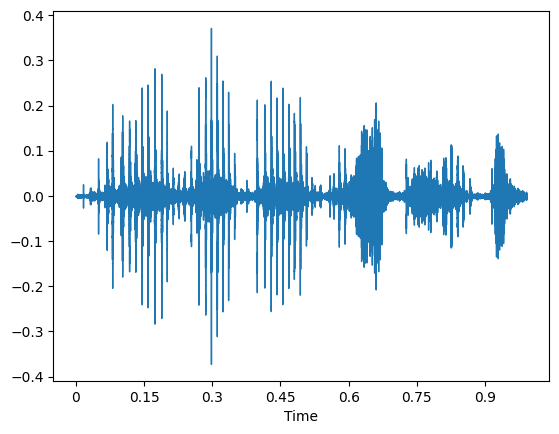

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [8]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan, set_seed
from IPython.display import Audio
from datasets import load_dataset
import soundfile as sf
import librosa
import torch
import matplotlib.pyplot

set_seed(42) # make results deterministic

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

inputs = processor(text="Hello, my dog is cute", return_tensors="pt")
speaker_embeddings = torch.zeros((1, 512))

# You can optionally use "speaker embeddings" to customize the output to a particular speaker’s voice characteristics
#embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
# speaker_embeddings = torch.tensor(embeddings_dataset[42]["xvector"]).unsqueeze(0)

spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
with torch.no_grad(): speech = vocoder(spectrogram)

# You can plot the generated spectrogram
# import matplotlib.pyplot as plt
# plt.figure()
# plt.imshow(spectrogram.T)
# plt.show()

librosa.display.waveshow(speech.numpy(), sr=16000) # You can plot the generated waveform
sf.write("tts_example.wav", speech.numpy(), samplerate=16000) # You can save the audio to a .wav file
display(Audio(speech.numpy(), rate=16000)) # You can hear the audio inputs

## Intermediate tasks:

* Connect the results from your answer to the previous intermediate task (i.e., conditioned language generation) to the SpeechT5 text-to-speech model, so as to produce speech outputs from the text generated by the model.
* Produce speech-based answers for the first 5 questions in the validation split from the SQuaD dataset.
* Connect also the results from your answer to the first intermediate task (i.e., automated speech recognition) to the SpeechT5 model and the LLM, so as to take spoken questions as input and produce a speech output.
* Collect small audio samples, with your own voice, for the first 5 questions in the validation split from the SQuaD dataset, and produce speech-based answers for these five questions.


In [10]:

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# PRODUCE SPEECH OUTPUTS FROM THE TEXT GENERATED BY THE MODEL #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Use SpeechT5 to produce speech outputs from the text generated by the model
i = 0
for prediction in predictions:
    inputs = processor(text=prediction, return_tensors="pt")
    speaker_embeddings = torch.zeros((1, 512))

    spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
    with torch.no_grad(): speech = vocoder(spectrogram)

    sf.write("task3.1/" + str(i) + ".wav", speech.numpy(), samplerate=16000) # You can save the audio to a .wav file
    i += 1


In [14]:

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#  TAKE SPOKEN QUESTIONS AS INPUT AND PRODUCE A SPEECH OUTPUT #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

from transformers import pipeline, set_seed
import librosa
from transformers import AutoProcessor, WhisperForConditionalGeneration
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan, set_seed

# Generate the text from the spoken questions
processor = AutoProcessor.from_pretrained("openai/whisper-medium.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-medium.en")

files = ["squad_0.wav", "squad_1.wav", "squad_2.wav", "squad_3.wav", "squad_4.wav"]
questions = []
for file in files:
    utt, st = librosa.load(file, sr=16000)
    utt = librosa.resample(utt, orig_sr=16000, target_sr=16000)
    inputs = processor(audio = utt, sampling_rate=16000, return_tensors="pt")
    predicted_ids = model.generate(**inputs, max_length=100)
    questions.append(processor.batch_decode(predicted_ids, skip_special_tokens=True))

# Apply the model to the transcriptions, to get the answer

# NOTE: the model is hardcoded because the evaluation of the best model was done separately in Google Colab
generator = pipeline(model='gpt2')

answers = []
for question in questions:
    print("Question: ", question[0])
    answer = generator(question[0] + " The answer is ", max_length=20, num_return_sequences=1)[0]['generated_text'][len(question[0] + " The answer is"):]
    print("Answer: ", answer)
    answers.append(answer)

# Produce speech-based answers for these five questions
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

i = 0
for answer in answers:
    inputs = processor(text=answer, return_tensors="pt")
    speaker_embeddings = torch.zeros((1, 512))

    spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
    with torch.no_grad(): speech = vocoder(spectrogram)

    sf.write("task3.2/" + str(i) + ".wav", speech.numpy(), samplerate=16000) # You can save the audio to a .wav file
    i += 1


KeyboardInterrupt: 

# Main problem

Students are tasked with joining together the speech recognition, language understanding and generation, and text-to-speech models, in order to build a conversational spoken question answering approach.

* The method should take as input speech utterances with questions.
* The language understanding and generation component should use as input a transcription for the current speech utterance, and optionally also transcriptions from previous speech utterances (i.e., the conversation context).
* The language understanding and generation component can explore different strategies for improving answer quality:
  * Use of large LLMs trained with reinforcement learning from human feedback.
  * Prompting the language model with retrieved in-context examples.
  * Using parameter-efficient fine-ting with existing conversational question answering datasets (e.g., [the CoQA dataset](https://stanfordnlp.github.io/coqa/), available from HuggingFace datasets).
  * ...
* The text-to-speech component takes as input the results from language generation, and produces a speech output.
* Both the automated speech recognition and the text-to-speech components can explore different approaches, although students should attempt to justify their choices (e.g., if changing the automated speech recognition component, show that it achieves a lower WER).
* Collect small audio samples, with your own voice, for the first two instances in the CoQA validation split, and show the results produced by your method for these examples.

In [107]:
import pandas as pd
import numpy as np
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
from transformers import AutoTokenizer, RobertaForQuestionAnswering, AutoProcessor

In [108]:
# Load CoQA train and dev partitions from json file
!curl -O https://downloads.cs.stanford.edu/nlp/data/coqa/coqa-train-v1.0.json
!curl -O https://downloads.cs.stanford.edu/nlp/data/coqa/coqa-dev-v1.0.json
ds_train = load_dataset('json', data_files='coqa-train-v1.0.json', field = 'data')
ds_dev = load_dataset('json', data_files='coqa-dev-v1.0.json', field = 'data')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46.7M  100 46.7M    0     0  1107k      0  0:00:43  0:00:43 --:--:-- 1653k  0   147k      0  0:05:23  0:00:01  0:05:22  148k
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  % Total    % Received % Xferd  Average Speed   Time    Time    

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /Users/duartealmeida/.cache/huggingface/datasets/json/default-5f06234cf437a380/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /Users/duartealmeida/.cache/huggingface/datasets/json/default-78a50877256fa1ff/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [109]:
# Pretrained models (increasing BLEU score)
#model = BertForQuestionAnswering.from_pretrained('bert-large-cased-whole-word-masking-finetuned-squad')
#tokenizer = BertTokenizer.from_pretrained('bert-large-cased-whole-word-masking-finetuned-squad')

model = RobertaForQuestionAnswering.from_pretrained('deepset/roberta-base-squad2')
tokenizer =  AutoTokenizer.from_pretrained('deepset/roberta-base-squad2')

In [110]:
# source: https://towardsdatascience.com/question-answering-with-a-fine-tuned-bert-bc4dafd45626
# This one is for the BERT
def question_answer(question, text):
    
    #tokenize question and text as a pair
    input_ids = tokenizer.encode(question, text)
    
    #string version of tokenized ids
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    #segment IDs
    #first occurence of [SEP] token
    sep_idx = input_ids.index(tokenizer.sep_token_id)
    #number of tokens in segment A (question)
    num_seg_a = sep_idx+1
    #number of tokens in segment B (text)
    num_seg_b = len(input_ids) - num_seg_a
    
    #list of 0s and 1s for segment embeddings
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    assert len(segment_ids) == len(input_ids)
    
    #model output using input_ids and segment_ids
    output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
    
    #reconstructing the answer
    answer_start = torch.argmax(output.start_logits)
    answer_end = torch.argmax(output.end_logits)
    answer = ""
    if answer_end >= answer_start:
        answer = tokens[answer_start]
        for i in range(answer_start+1, answer_end+1):
            if tokens[i][0:2] == "##":
                answer += tokens[i][2:]
            else:
                answer += " " + tokens[i]
                
    if answer.startswith("[CLS]"):
        answer = "Unable to find the answer to your question."
    #print("\nPredicted answer:\n{}".format(answer.capitalize()))
    return answer
    

In [111]:
# This one is for roberta
import torch
def question_answer_2(question, text):
    inputs = tokenizer(question, text, return_tensors="pt")
    with torch.no_grad():
      outputs = model(**inputs)
    #print(outputs.start_logits)
    #print(output.end_logits)
    answer_start_index = outputs.start_logits.argmax()
    answer_end_index = outputs.end_logits.argmax()

    predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
    output = tokenizer.decode(predict_answer_tokens, skip_special_tokens=True)
    return output

In [ ]:
from tqdm import tqdm
from transformers import logging

logging.set_verbosity_error()

i = 0
predictions = []
references = []


# Evaluate Language Model on Dev parition
for (i, sample) in tqdm(enumerate(ds_dev["train"]), total=25):
    questions = sample["questions"]
    answer_sets = [answer_set for answer_set in zip(sample["answers"], sample["additional_answers"]["0"],
                  sample["additional_answers"]["1"], sample["additional_answers"]["2"])]
    for (question, answer_set) in zip(questions, answer_sets):
        predictions.append(question_answer_2(question["input_text"], sample["story"]))
        references.append([a["input_text"] for a in answer_set])
        print(f"Prediced answer: {predictions[-1]}")
        print(f"Real answers: {references[-1]}")
    i += 1
    if (i == 25): # To speedup the process
        break
    
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=references)
print(results)

  0%|                                                                                                      | 0/25 [00:00<?, ?it/s]

Prediced answer:  white
Real answers: ['white', 'white', 'white', 'white']
Prediced answer:  a barn near a farm house
Real answers: ['in a barn', 'in a barn', 'in a barn', 'in a barn near']
Prediced answer:  Cotton wasn't alone
Real answers: ['no', 'no', 'No', 'no']
Prediced answer:  her mommy and 5 other sisters
Real answers: ['with her mommy and 5 sisters', 'her mommy and 5 other sisters', 'her mommy and 5 other sisters', 'her mommy and 5 other sisters']
Prediced answer:  orange
Real answers: ['orange and white', 'orange with white tiger stripes', 'orange', 'orange']
Prediced answer:  sad
Real answers: ['no', 'no', 'No', 'no']
Prediced answer:  orange paint
Real answers: ['she painted herself', 'she painted herself', 'paint herself like them', 'paint herself like them']
Prediced answer:  farmer's orange
Real answers: ['the farmer', "the farmer's", "the old farmer's", "the farmer's"]
Prediced answer:  started laughing
Real answers: ['they started laughing', 'they started laughing', 'r

  4%|███▊                                                                                          | 1/25 [00:14<05:45, 14.38s/it]

Prediced answer: 
Real answers: ['no', 'no', 'No', 'no']
Prediced answer:  Asta
Real answers: ['Asta.', 'Asta', 'Asta', 'Asta']
Prediced answer: 
Real answers: ['a bottle', 'a bottle', 'the bottle', 'a bottle']
Prediced answer:  Sharkie
Real answers: ['Asta.', 'Asta', 'Sharkie', 'Asta']
Prediced answer:  Sharkie could not read the note
Real answers: ['Yes', 'yes', 'yes', 'yes']
Prediced answer:  When they got it open
Real answers: ['Yes', 'yes', 'yes', 'yes']
Prediced answer:  a note
Real answers: ['a note', 'a note', 'a note', 'a note']
Prediced answer:  Asta could not read the note
Real answers: ['No', 'no', 'no', 'no']
Prediced answer: 
Real answers: ["Asta's papa", "Asta's papa", "Asta's papa", "Asta's papa"]
Prediced answer:  send it to her
Real answers: ['unknown', "They took the note to Asta's papa", "They took the note to Asta's papa", "They took the note to Asta's papa."]
Prediced answer:  we can write a note to her. But you have to find another bottle so we can send it to her

  8%|███████▌                                                                                      | 2/25 [00:26<04:58, 12.96s/it]

Prediced answer: were they excitedOnce there was a beautiful fish named Asta. Asta lived in the ocean. There were lots of other fish in the ocean where Asta lived. They played all day long
Real answers: ['unknown', 'unknown', 'unknown', 'unknown']
Prediced answer:  elderly Chinese lady
Real answers: ['An elderly Chinese lady and a little boy', 'elderly Chinese lady', 'an elderly Chinese lady', 'elderly Chinese lady']
Prediced answer:  a paper carrier bag
Real answers: ['Yes', 'a little boy', 'yes', 'yes']
Prediced answer: 
Real answers: ['a paper carrier bag', 'a little boy', 'a paper carrier bag.', 'paper carrier bag']
Prediced answer: I know this lady
Real answers: ['Yes', 'Yes', 'yes', 'yes']
Prediced answer:  Nicole
Real answers: ['Nicole', 'her daughter bought the house next door', 'Nicole', 'his neighbor']
Prediced answer:  Shanghai
Real answers: ['Shanghai', 'Shanghai', 'next door', 'house next door']
Prediced answer:  grandmother
Real answers: ['mother', 'her brother', 'grandmo

 12%|███████████▎                                                                                  | 3/25 [00:48<06:21, 17.36s/it]

Prediced answer: Thank you"
Real answers: ['"Thank you"', 'Thank you', '"Thank you"', '"Thank you"']
Prediced answer:  Dennis Farina
Real answers: ['Yes.', 'yes', 'yes', 'yes']
Prediced answer:  Dennis Farina
Real answers: ['Dennis Farina', 'Dennis Farina', 'Dennis Farina', 'Dennis Farina']
Prediced answer:  69. 

"We are deeply saddened by the loss of a great actor and a wonderful man," said his publicist, Lori De Waal, in a statement Monday. "Dennis Farina was always warmhearted and professional, with a great sense of humor and passion for his profession. He will be greatly missed by his family, friends and colleagues." 

Farina, who had a long career as a police officer in Chicago, got into acting through director Michael Mann, who used him as a consultant and cast him in his 1981 movie, "Thief." That role led to others in such Mann-created shows as "Miami Vice" (in which Farina played a mobster) and "Crime Story" (in which he starred as Lt. Mike Torello). 

Farina also had roles, g

 16%|███████████████                                                                               | 4/25 [01:14<07:14, 20.70s/it]

Prediced answer: 
Real answers: ['A cop', 'a police officer', 'cop', 'cop']
Prediced answer: 
Real answers: ['school', 'school', 'school', 'school']
Prediced answer:  Kendra lives further from the bus stop than Quinton does
Real answers: ['No', 'no', 'no', 'no']
Prediced answer:  go in for cookies and milk
Real answers: ["go to Quentin's house", 'get cookies and milk', 'they go in for cookies and milk', 'go in for cookies and milk']
Prediced answer:  Quinton can't
Real answers: ['No', 'no', 'no', 'no']
Prediced answer:  when they are done they play together
Real answers: ['No', 'no', 'no', 'no']
Prediced answer:  story time
Real answers: ['story time', 'story time', 'story time', 'story time']
Prediced answer: 
Real answers: ['right before bedtime', 'right before bedtime.', 'right before bedtime', 'before bedtime']
Prediced answer:  no one answered
Real answers: ['no one answered', 'no answer', 'no one answered', 'no one answered']
Prediced answer:  She saw that Quinton's mother's car 

 20%|██████████████████▊                                                                           | 5/25 [01:36<07:02, 21.13s/it]

Prediced answer:  tomorrow
Real answers: ['yes', 'after lunch', 'after lunch', 'after lunch']
Prediced answer: 
Real answers: ['five', 'five', 'five', 'five']
Prediced answer: 
Real answers: ['New York City', 'New York City', 'New York City', 'New York City']
Prediced answer:  New York
Real answers: ['New York', 'New York.', 'New York', 'New York']
Prediced answer: Staten Island is one of the five boroughs
Real answers: ['Yes', 'yes', 'yes', 'yes']
Prediced answer: Staten Island is one of the five boroughs of New York City in the U.S. state of New York
Real answers: ['In the southwest of the city', 'In the southwest of the city', 'the southernmost part of both the city and state of New York', 'southernmost part of both the city and state of New York']
Prediced answer:  Arthur Kill and the Kill Van Kull
Real answers: ['Arthur Kill and the Kill Van Kull', 'the Arthur Kill and the Kill Van Kull,', 'the Arthur Kill and the Kill Van Kull', 'Arthur Kill and the Kill Van Kull']
Prediced answe

 24%|██████████████████████▌                                                                       | 6/25 [01:50<05:55, 18.71s/it]

Prediced answer:  St. George, Tompkinsville, Clifton, and Stapleton
Real answers: ['St. George, Tompkinsville, Clifton, and Stapleton', 'St. George, Tompkinsville, Clifton, and Stapleton', 'St. George, Tompkinsville, Clifton, and Stapleton', 'St. George, Tompkinsville, Clifton, and Stapleton']
Prediced answer:  five in the morning
Real answers: ['Five in the morning', 'five in the morning', 'five in the morning', 'five in the morning']
Prediced answer:  the weather forecast
Real answers: ['Weather forecast', 'the weather forecast', 'the weather forecast', 'the weather forecast']
Prediced answer:  A violent storm was coming
Real answers: ['Yes', 'yes', 'yes', 'Yes']
Prediced answer:  firefighter
Real answers: ['Firefighter', 'firefighter', 'firefighter', 'a firefighter']
Prediced answer:  The house lights went off
Real answers: ['Yes', 'yes', 'yes', 'Yes']
Prediced answer:  flashlight
Real answers: ['Flashlight', 'flashlight', 'flashlight', 'flashlight']
Prediced answer:  R.J.
Real answ

 28%|██████████████████████████▎                                                                   | 7/25 [02:07<05:27, 18.22s/it]

Prediced answer:  his father's flashlight
Real answers: ['The flashlight', "the light of his father's flashlight.", "the light of his father's flashlight.", "his father's flashlight"]
Prediced answer:  Gary Giordano
Real answers: ['Gary Giordano', 'the suspect', 'Gary Giordano', 'Gary Giordano']
Prediced answer:  Gaithersburg
Real answers: ['Gaithersburg', 'Gaithersburg', 'Maryland', 'Gaithersburg']
Prediced answer:  Montgomery
Real answers: ['Montgomery County', 'Montgomery', 'Gaithersburg', 'Montgomery County']
Prediced answer: 
Real answers: ['Maryland', 'Maryland', 'Maryland', 'Maryland']
Prediced answer:  Aruban jail
Real answers: ['Aruban jail', 'Aruban jail', 'Aruba', 'an Aruban jail']
Prediced answer: Why?(CNN) -- FBI agents on Friday night searched the Maryland home of the suspect in the recent disappearance of an American woman in Aruba
Real answers: ['suspect in the recent disappearance of an American woman', 'he is the suspect in the disappearance of an American woman', 'su

 32%|██████████████████████████████                                                                | 8/25 [02:34<05:54, 20.84s/it]

Prediced answer: 
Real answers: ['2, Giordano told authorities that he had been snorkeling with Gardner', 'Two', 'Two', 'Two']
Prediced answer: 
Real answers: ['Great Britain', 'Great Britain', 'India', 'Great Britain']
Prediced answer:  India
Real answers: ['India.', 'India', 'India.', 'India']
Prediced answer:  30 feet
Real answers: ['may be 30 feet tall', '30 feet tall.', '30 feet tall', '30 feet tall']
Prediced answer:  steamed
Real answers: ['prune it', 'They steam it.', 'Steam it', 'steam it']
Prediced answer: 
Real answers: ['may prevent heart disease.', 'It may prevent heart disease.', 'Prevent heart disease', 'may prevent heart disease']
Prediced answer: 
Real answers: ['by accident', 'Leaves from a wild tea tree fell into a hot water pot.', 'By accident.', 'Leaves fell into the hot water']
Prediced answer: Who took the tea first?Which country grows the most tea? The answer is India. It grows three times as much as China. Which country drinks the most tea? It's neither China n

 36%|█████████████████████████████████▊                                                            | 9/25 [02:47<04:53, 18.36s/it]

Prediced answer: 
Real answers: ['unknown', 'unknown', 'unknown', 'unknown']
Prediced answer:  Der Spiegel
Real answers: ['Der Spiegel', 'Der Spiegel', 'Der Spiegel', 'Der Spiegel']
Prediced answer:  German
Real answers: ['Germany', 'Germany', 'Germany', 'Germany']
Prediced answer:  posing over the bodies of dead Afghans
Real answers: ['posing over the bodies of dead Afghans', 'posing over the bodies of dead Afghans', 'posing over the bodies of dead Afghans', 'posing over the bodies of dead Afghans']
Prediced answer:  bloody
Real answers: ['bloody', 'bloody', 'bloody', 'bloody']
Prediced answer:  kneeling by a bloody body sprawled over a patch of sand and grass
Real answers: ['propped up, back to back', 'two bodies propped up', 'what appears to be two bodies propped up,', 'two bodies propped up']
Prediced answer:  a patch of sand and grass
Real answers: ['military vehicle.', 'a military vehicle', 'in front of a military vehicle', 'in front of a military vehicle']
Prediced answer: takin

 40%|█████████████████████████████████████▏                                                       | 10/25 [02:58<04:01, 16.08s/it]

Prediced answer:  premeditated deaths of three civilians
Real answers: ['Holmes is charged with the premeditated deaths of three civilians', 'The premeditated deaths of three civilians, possessing a dismembered human finger, wrongfully possessing photographs of human casualties, and smoking hashish.', 'the premeditated deaths of three civilians', 'the premeditated deaths of three civilians']
Prediced answer:  Floyd Mayweather and Filipino Manny Pacquiao
Real answers: ['Floyd Mayweather and Manny Pacquiao', 'Floyd Mayweather and Manny Pacquiao', 'Floyd Mayweather and Manny Pacquiao', 'Floyd Mayweather and Manny Pacquiao']
Prediced answer: 
Real answers: ['1 is the money man', 'The Money Man', '"The Money Man"', '"The Money Man"']
Prediced answer: what is the other(CNN)A chiseled boxer's Instagram feed shows him making constant references to the Bible and enjoying gospel singing with his wife. 

Another features his formidable opponent counting stacks of money, hanging out in strip clubs

 44%|████████████████████████████████████████▉                                                    | 11/25 [03:10<03:30, 15.02s/it]

Prediced answer:  he's the hope of a nation
Real answers: ['just that it has bible references and shows him enjoying gos[e; singing with his wife', "he's the hope of a nation", "he's the hope of a nation", 'hope of a nation']


In [11]:
generator = pipeline(model = "declare-lab/flan-alpaca-base")

In [103]:
from tqdm import tqdm
from transformers import logging

logging.set_verbosity_error()

i = 0
predictions = []
references = []

# Evaluate Language Model on Dev parition
for (i, sample) in tqdm(enumerate(ds_dev["train"]), total=25):
    questions = sample["questions"]
    answer_sets = [answer_set for answer_set in zip(sample["answers"], sample["additional_answers"]["0"],
                  sample["additional_answers"]["1"], sample["additional_answers"]["2"])]
    for (question, answer_set) in zip(questions, answer_sets):
        prompt = sample["story"]
        if prompt[-1] != ".":
            prompt += "."
        prompt += " " + question["input_text"]
        if prompt[-1] != "?":
            prompt += "?"
        predictions.append(generator(prompt, max_length=20, num_return_sequences=1,  pad_token_id=generator.tokenizer.eos_token_id)[0]["generated_text"])
        references.append([a["input_text"] for a in answer_set])

    i += 1
    if (i == 25):
        break
    
    
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=references)
print(f"Bleu score: {results['bleu']}")

  5%|████▎                                                                                     | 24/500 [14:20<4:44:35, 35.87s/it]


KeyboardInterrupt: 